In [ ]:
import pandas as pd
from pandas import Series 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import collections
from datetime import datetime
import dateutil
import scipy
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import dateutil
from dateutil.relativedelta import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as spc
import math 

In [ ]:
df = pd.read_csv('./dataport-export_gas_oct2015-mar2016.csv')

## Overview of the Data

In [ ]:
df.head()

localminute  dataid  meter_value
0  2015-10-01 00:00:10-05     739        88858
1  2015-10-01 00:00:13-05    8890       197164
2  2015-10-01 00:00:20-05    6910       179118
3  2015-10-01 00:00:22-05    3635       151318
4  2015-10-01 00:00:22-05    1507       390354

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584823 entries, 0 to 1584822
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   localminute  1584823 non-null  object
 1   dataid       1584823 non-null  int64 
 2   meter_value  1584823 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 36.3+ MB


In [ ]:
df.describe()
df.dtypes

localminute    object
dataid          int64
meter_value     int64
dtype: object

## Question 1.1
- Identify the number of houses in the measurement study 
- Identify the malfunctioning meters and the time period of malfunctioning


In [ ]:
houses = df["dataid"].unique()
print(len(houses))

157


In [ ]:
print(houses) #the houses the study

[ 739 8890 6910 3635 1507 5810  484 4352 1718 1714 9849 5131 6412 7429
  871 1086 1589 8156 9631 5403 4447 2034 5275 7794 7287 4296 9639 7017
  252 8829   94 3039 9121 7741 7919 7674 7030 4732  370 9295 3577  222
 2449   35 1697 9134 4767 5785 7739 7117 5193 3367 8467 5972 5439  114
 9474 2335 7460 4998 9278 5129 2018 9052 9956 8155  483 1556 5636 4029
 3544 1791 1801 9729 1283 1792 4031 3893 1185 7682 2638  187 3723 4514
 5814   77 1619 4421  661 3134 6836 1042 4373 5484 2072 2461  744 9982
 1790 1800 2980 2094 5892 7900 8084 3527 3849 4356 2129 2965 2575 8086
 1415 2233 6863 2470 3778 2378 6830 9766 4193 8703 6578 4228 2645 6505
 5395 8059 7965   44 4671 6685 7989 2945 2818 7016 8967 3310 3918 8386
 1103 9620 5658 5545 5317 3036 9160 8244 2755 9600 2946 1403 7566 6673
 2814 6101 4874]


There are 157 households participating in the measurement study. 

How the we define the malfunctioning meters:

- Decrease in Gas Consumption Meter, it should only increase
- No reading updated for more than one week, meter might be tampered with / not working
- A increased in consumption over a short period of time.
- Meter with too little readings, meter might not be working to provide regular updates. 

In [ ]:
#Using group dataframe for meter id and parse datetime with dateutil library
df['localminute']=df['localminute'].apply(dateutil.parser.parse)

group_df = df.groupby(['dataid'])

In [ ]:
group_df.describe()
group_df.dtypes

localminute meter_value
dataid                        
35          object       int64
44          object       int64
77          object       int64
94          object       int64
114         object       int64
...            ...         ...
9729        object       int64
9766        object       int64
9849        object       int64
9956        object       int64
9982        object       int64

[157 rows x 2 columns]

## Overall Data Plot 
In this section, we will be plotting every meter in the data file to look at its gas consumption usage. 
The plot will show each meter's reading starting from 1st October 2015 in a cumulative manner till March 2016, through the plotted graph, we see that the abnormaly (malfunctioning) affects the trend of the graph. 

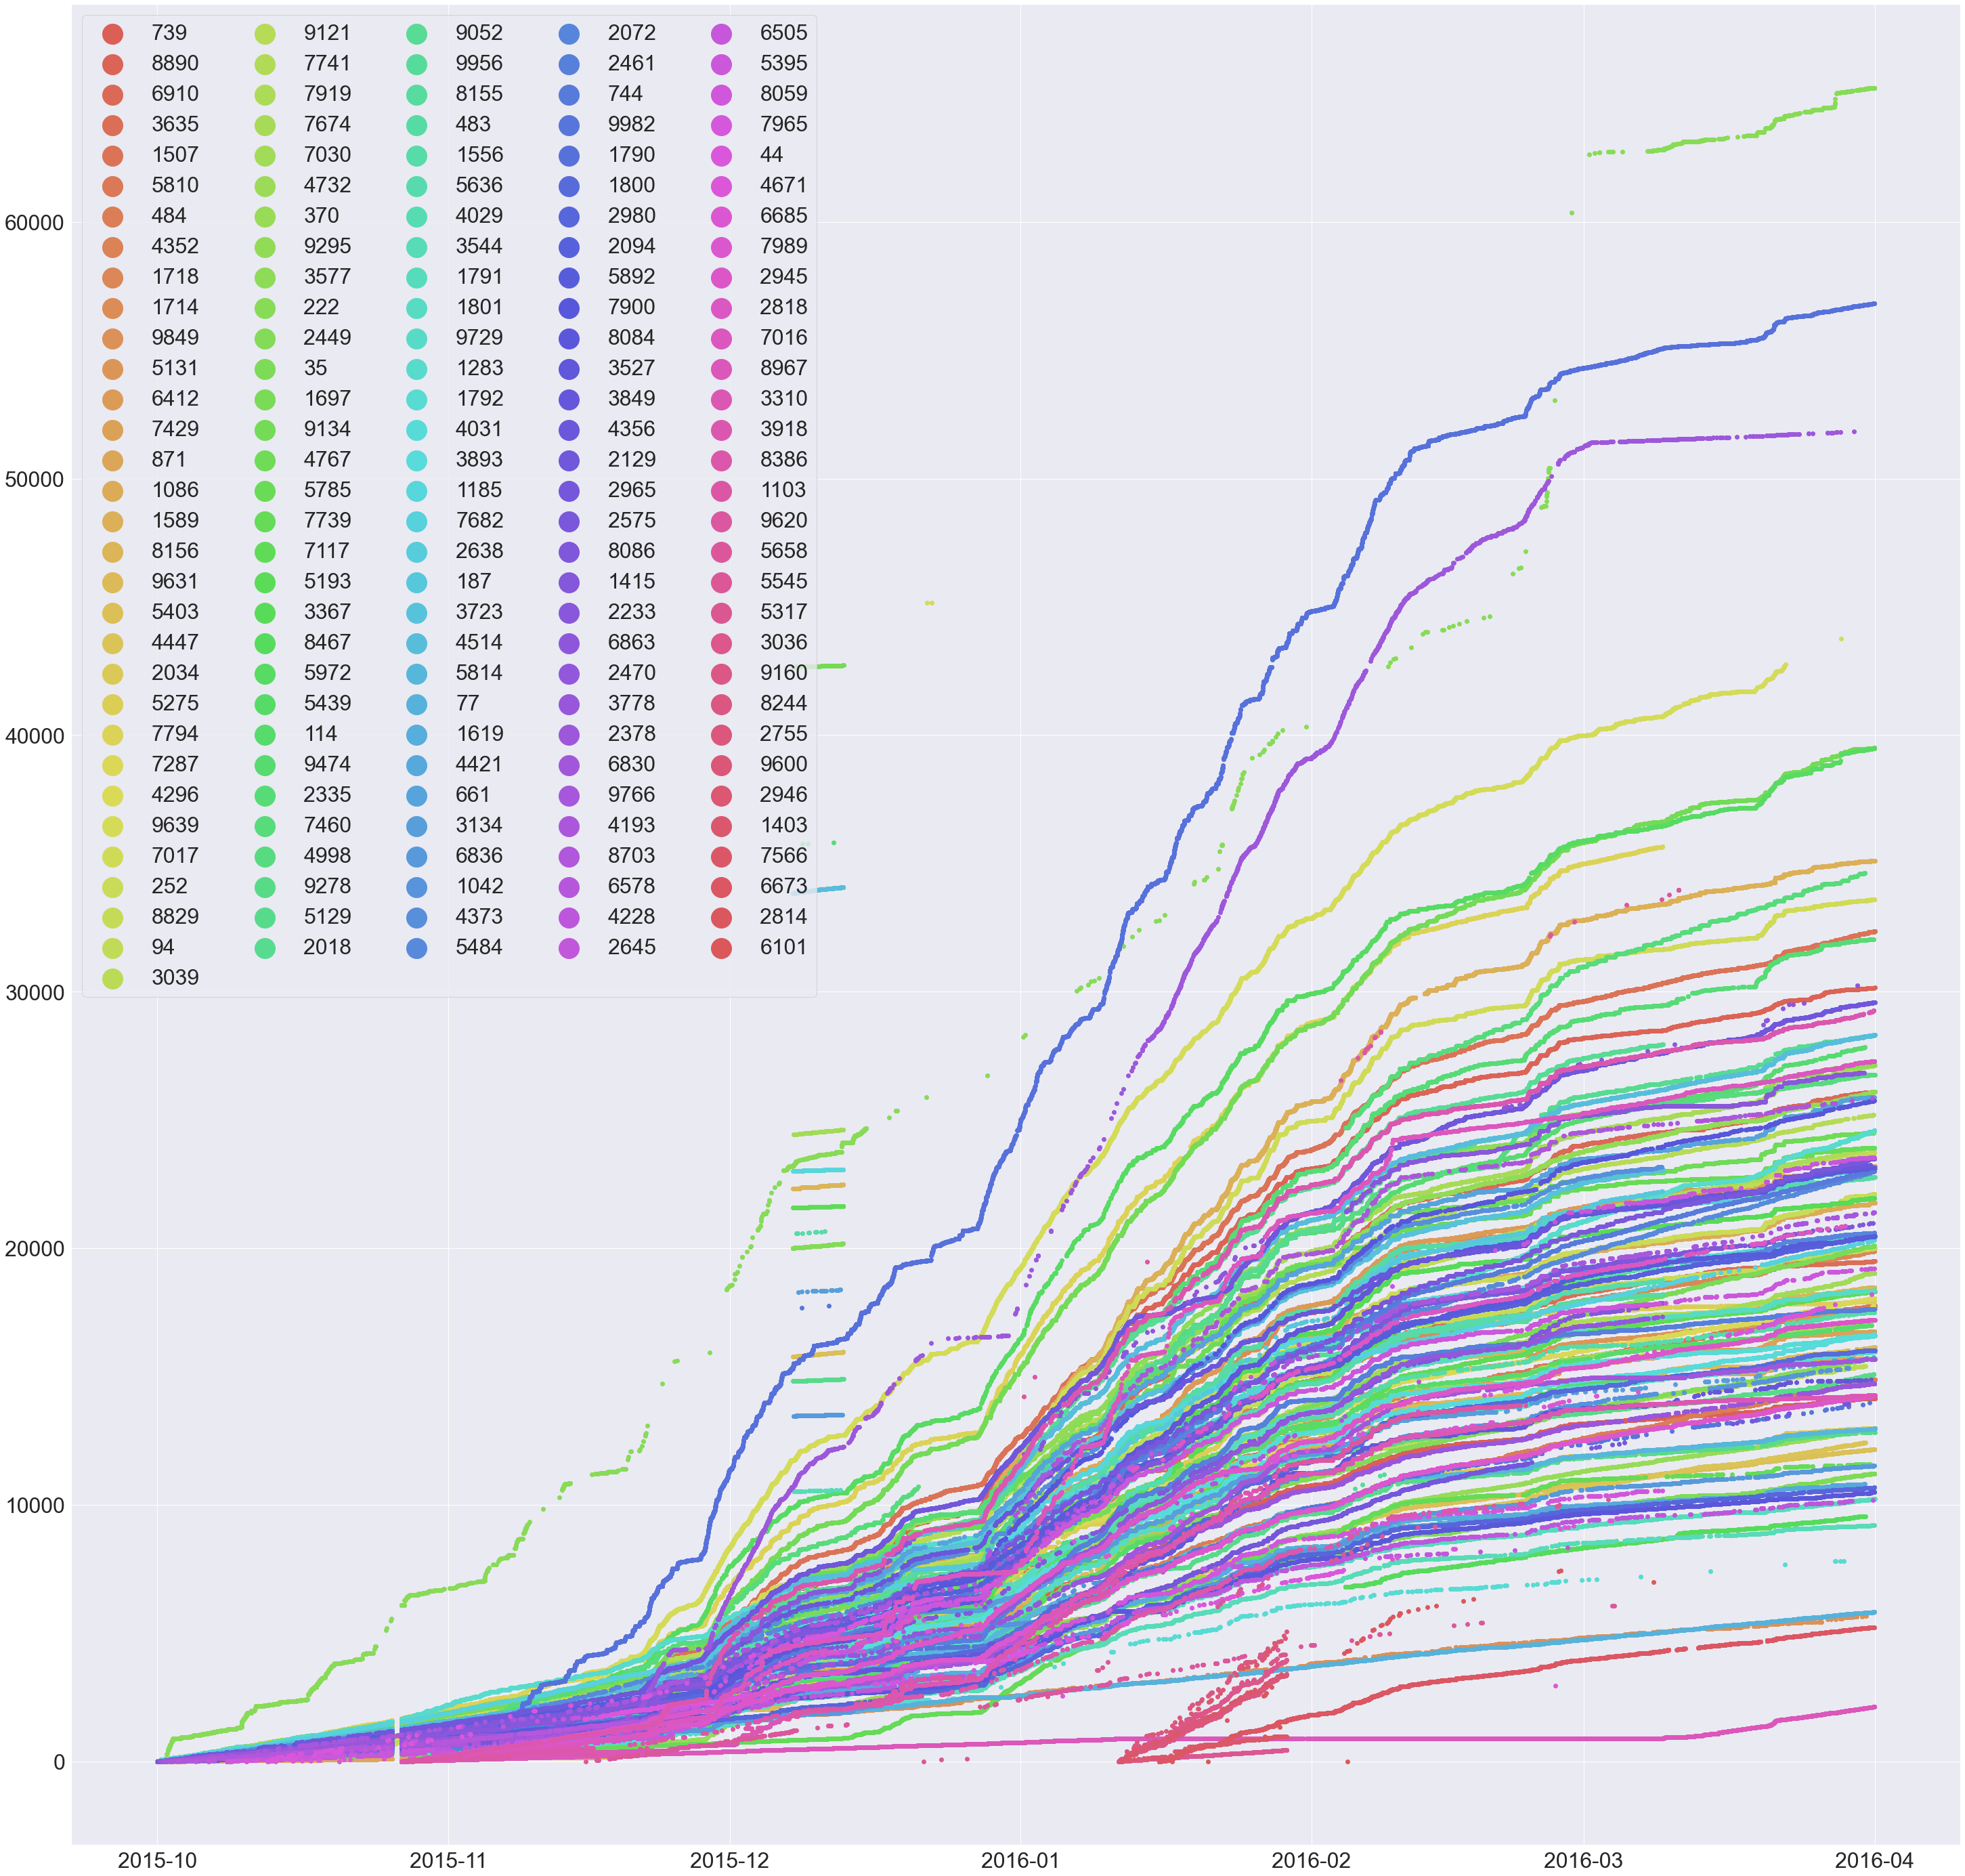

In [ ]:
sns.set_palette(sns.color_palette("hls", 157))
plt.subplots(figsize=(50,50))
for dataid in houses:
    value = group_df.get_group(dataid).meter_value.values - group_df.get_group(dataid).meter_value.values[0]
    #The first index is the value as of 1 Oct 2015, minus so we can take the value within the 6 months
       
    plt.legend(houses, ncol=5, loc='best',fontsize = 32, markerscale = 5);
    plt.scatter(group_df.get_group(dataid).localminute.values, value)
    plt.xticks(fontsize = 32)
    plt.yticks(fontsize = 32)

## Analysis from the overall graph
In the graph, it is observed that there are abnormalities during the period of December 2015. To further analyse these abnormalities, we will consider these abnormalities in a few sections. 

## Q1.1 
### 1.1(a) The gas meter should be cumulative and should not decrease. To consider possible fluctuations due to meter reading being old and maybe insensitive. The group has catered a 3cm^3 threshold, before its considered as a malfunction. 

In [ ]:
malfunction_meter_decrease = {}
for meter,house in group_df:
    prev_reading = 0
    for n, meterval in enumerate(house["meter_value"]):
        if (prev_reading) > (meterval + 3):
            malfunction_meter_decrease.setdefault(meter, [])
            malfunction_meter_decrease[meter].append(str(house.iloc[n]["localminute"]))
            
        prev_reading = meterval  
print(f"Number of malfunction meter with decrease value: {len(malfunction_meter_decrease)} \n")
for key in malfunction_meter_decrease:
    print(f"Meter {key} malfunctioned on {(', '.join(malfunction_meter_decrease[key]))}\n")
   

    

Number of malfunction meter with decrease value: 28 

Meter 94 malfunctioned on 2015-11-01 01:11:10-06:00, 2015-11-01 01:17:53-06:00, 2015-11-01 01:23:12-06:00, 2016-01-16 10:23:43.197562-06:00, 2016-01-18 11:19:47.220413-06:00, 2016-01-18 11:26:52.211985-06:00

Meter 483 malfunctioned on 2015-10-21 00:18:54-05:00

Meter 484 malfunctioned on 2016-03-05 00:01:58.770374-06:00

Meter 1185 malfunctioned on 2015-10-17 12:33:57-05:00, 2015-10-17 13:27:01-05:00, 2015-10-17 13:40:02-05:00, 2015-10-20 12:29:48-05:00, 2015-10-20 13:49:08-05:00, 2015-12-07 17:19:59-06:00, 2015-12-07 18:21:50-06:00, 2015-12-07 19:58:12-06:00, 2015-12-07 20:12:12-06:00, 2015-12-07 20:34:59-06:00, 2015-12-07 21:20:06-06:00, 2015-12-07 21:58:58-06:00, 2015-12-07 23:09:55-06:00, 2015-12-08 01:05:02-06:00, 2015-12-08 01:52:51-06:00, 2015-12-08 02:06:59-06:00, 2015-12-08 02:15:55-06:00, 2015-12-08 03:58:05-06:00, 2015-12-08 04:49:06-06:00, 2015-12-08 06:15:55-06:00, 2015-12-08 06:35:56-06:00, 2015-12-08 07:07:52-06:00, 

To conclude, the meters that malfunctioned in Q1.1(a), in the first section of analysis. 

In [ ]:
print(f"Malfunction meters due to decreased reading : {(' '.join(str(key) for key in malfunction_meter_decrease.keys()))} \n" )
print(f"Quantity of faulty meters due to decreased reading {(len(malfunction_meter_decrease))}.")

Malfunction meters due to decreased reading : 94 483 484 1185 1556 1718 2335 2449 3134 3544 4031 4514 4998 5129 5193 5403 5810 6836 7017 7030 7117 7794 7989 8156 8890 9134 9639 9982 

Quantity of faulty meters due to decreased reading 28.


### 1.1(b) Gas meters with data not reported over a long duration is considered as malfunctioned. To consider possible scenarios like meters being in maintenance and reasons that requires meters to shut down. The group has catered a duration of 10 days as the threshold.

In [ ]:
malfunction_meter_not_reported={}

for meter,group in group_df:    
    time_diff=0    
    for i in range(len(group['localminute'])):
        if (i!=0):
            time_diff=(group['localminute'].iloc[i]-group['localminute'].iloc[i-1]).total_seconds() / (3600*24) 
        if(time_diff>= 10):
            malfunction_meter_not_reported[meter] = (str(house.iloc[n]["localminute"]))
            break
print(f"Number of malfunction meter with data not reported: {len(malfunction_meter_not_reported)} \n")
for key in malfunction_meter_not_reported:
    print(f"Meter {key} malfunctioned on {malfunction_meter_not_reported[key]}\n")


Number of malfunction meter with data not reported: 26 

Meter 44 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 2233 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 2638 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 2645 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 2965 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 3039 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 4352 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 4421 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 4447 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 4671 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 4874 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 5545 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 5658 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 6505 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 6578 malfunctioned on 2016-03-31 11:09:42.788433-05:00

Meter 6685 malf

To conclude, the meters that malfunctioned in Q1.1(b), in the second section of analysis. 

In [ ]:
print(f"Malfunction meters due to no reading over 10 days: {(' '.join(str(key) for key in malfunction_meter_not_reported.keys()))} \n" )
print(f"Quantity of faulty meters due to no reading {(len(malfunction_meter_not_reported))}.")

Malfunction meters due to no reading over 10 days: 44 2233 2638 2645 2965 3039 4352 4421 4447 4671 4874 5545 5658 6505 6578 6685 6863 7460 7919 7965 8059 8467 8703 9474 9620 9956 

Quantity of faulty meters due to no reading 26.


### 1.1(c) Gas meters with data a sudden increase in reading over a short duration of time is considered as malfunctioned. To consider possible scenarios like the highest consumption in a day, the the threshold is being set 560 cubic feet.

Texas have approximately 7.4 millions of households, the natural gas consumption in a single month from October 2015 to March 2016 should not exceed 41423 million cubic feet. Reference: https://www.eia.gov/dnav/ng/hist/n3010tx2m.htm

To get a rough estimate of the  natural gas consumption per household in a day we have calculated it as such 
41423 millions/(7.4 millions * 28) = 200 cubic feet
We divide it by 28 as February is the shortest month within the year. 

Because that is an average, there will be some household that have much higher consumption (retired residents), thus we multiply it by a factor of 3 to get a treshhold of ~600 cubic feet per day.

Thus we should not observe any reading that is higher than 600 cubic feet in a single day else, it is likely to be a meter malfunction

In [ ]:
previous_meter = 0
current_meter = 0
previous_date = ""
malfunction_sudden_increase = {}

for meter, house in group_df:
    for n, dt in enumerate(house['localminute']):   
        current_meter = house.iloc[n]["meter_value"]
        if n == 0:
            previous_date = dt.date()
            
        if previous_date == dt.date():
            previous_meter = house.iloc[n]["meter_value"]
            previous_date = dt.date()
               
        else:
            time = (dt.date() - previous_date)
            day = (time.total_seconds()/(3600*24))
            if (previous_meter - current_meter) / day > 600:
                malfunction_sudden_increase.setdefault(meter, [])
                malfunction_sudden_increase[meter].append(str(house.iloc[n]["localminute"]))
            previous_date = dt.date()
           

print(f"Number of malfunction meter with sudden increase in value: {len(malfunction_sudden_increase)} \n")
for key in malfunction_sudden_increase:
    print(f"Meter {key} malfunctioned on {(', '.join(malfunction_sudden_increase[key]))} \n")


Number of malfunction meter with sudden increase in value: 9 

Meter 2449 malfunctioned on 2015-12-10 00:25:19-06:00, 2015-12-13 00:27:19-06:00 

Meter 3134 malfunctioned on 2015-12-10 00:51:37-06:00 

Meter 3544 malfunctioned on 2015-12-09 08:24:43-06:00 

Meter 4514 malfunctioned on 2015-12-11 00:04:00-06:00 

Meter 5403 malfunctioned on 2015-12-10 00:09:19-06:00, 2015-12-12 00:13:02-06:00 

Meter 6836 malfunctioned on 2015-12-12 00:19:35-06:00 

Meter 7030 malfunctioned on 2015-12-10 00:01:25-06:00 

Meter 8156 malfunctioned on 2015-12-13 00:01:41-06:00 

Meter 9134 malfunctioned on 2015-12-10 00:23:05-06:00 



In [ ]:
print(f"Malfunction meters due to sudden increase reading : {(' '.join(str(key) for key in malfunction_sudden_increase.keys()))} \n" )
print(f"Quantity of faulty meters due to sudden increase reading {(len(malfunction_sudden_increase))}.")

Malfunction meters due to sudden increase reading : 2449 3134 3544 4514 5403 6836 7030 8156 9134 

Quantity of faulty meters due to sudden increase reading 9.


### 1.1(d) Gas meters with a small number of data readings across the full 6 months is quite suspicious, as such, the group has set a threshold of 50 readings as the bare minimum.  

In [ ]:
malfunction_little_readings = {}
for meter,house in group_df:
    if(len(house['meter_value'])< 200):
        malfunction_little_readings[meter] = len(house['meter_value'])
        

In [ ]:
print(f"Malfunction meters due to little readings : {(' '.join(str(key) for key in malfunction_little_readings.keys()))} \n" )
print(f"Quantity of faulty meters due to little readings {(len(malfunction_little_readings))}.")

Malfunction meters due to little readings : 2645 2755 2814 2946 4671 4874 5545 6101 6685 7566 9160 9620 

Quantity of faulty meters due to little readings 12.


In [ ]:
malfunction = {**malfunction_meter_decrease, **malfunction_meter_not_reported, **malfunction_sudden_increase, **malfunction_little_readings}

## Conclusion
Total number of malfunctioning meters: Sum the number of malfunctioning meters in 1.1(a), 1.1(b), 1.1(c) and 1.1(d)

In [ ]:
len(malfunction)

60

### Results 
As such, we will plot the malfunctioning meters all in one graph

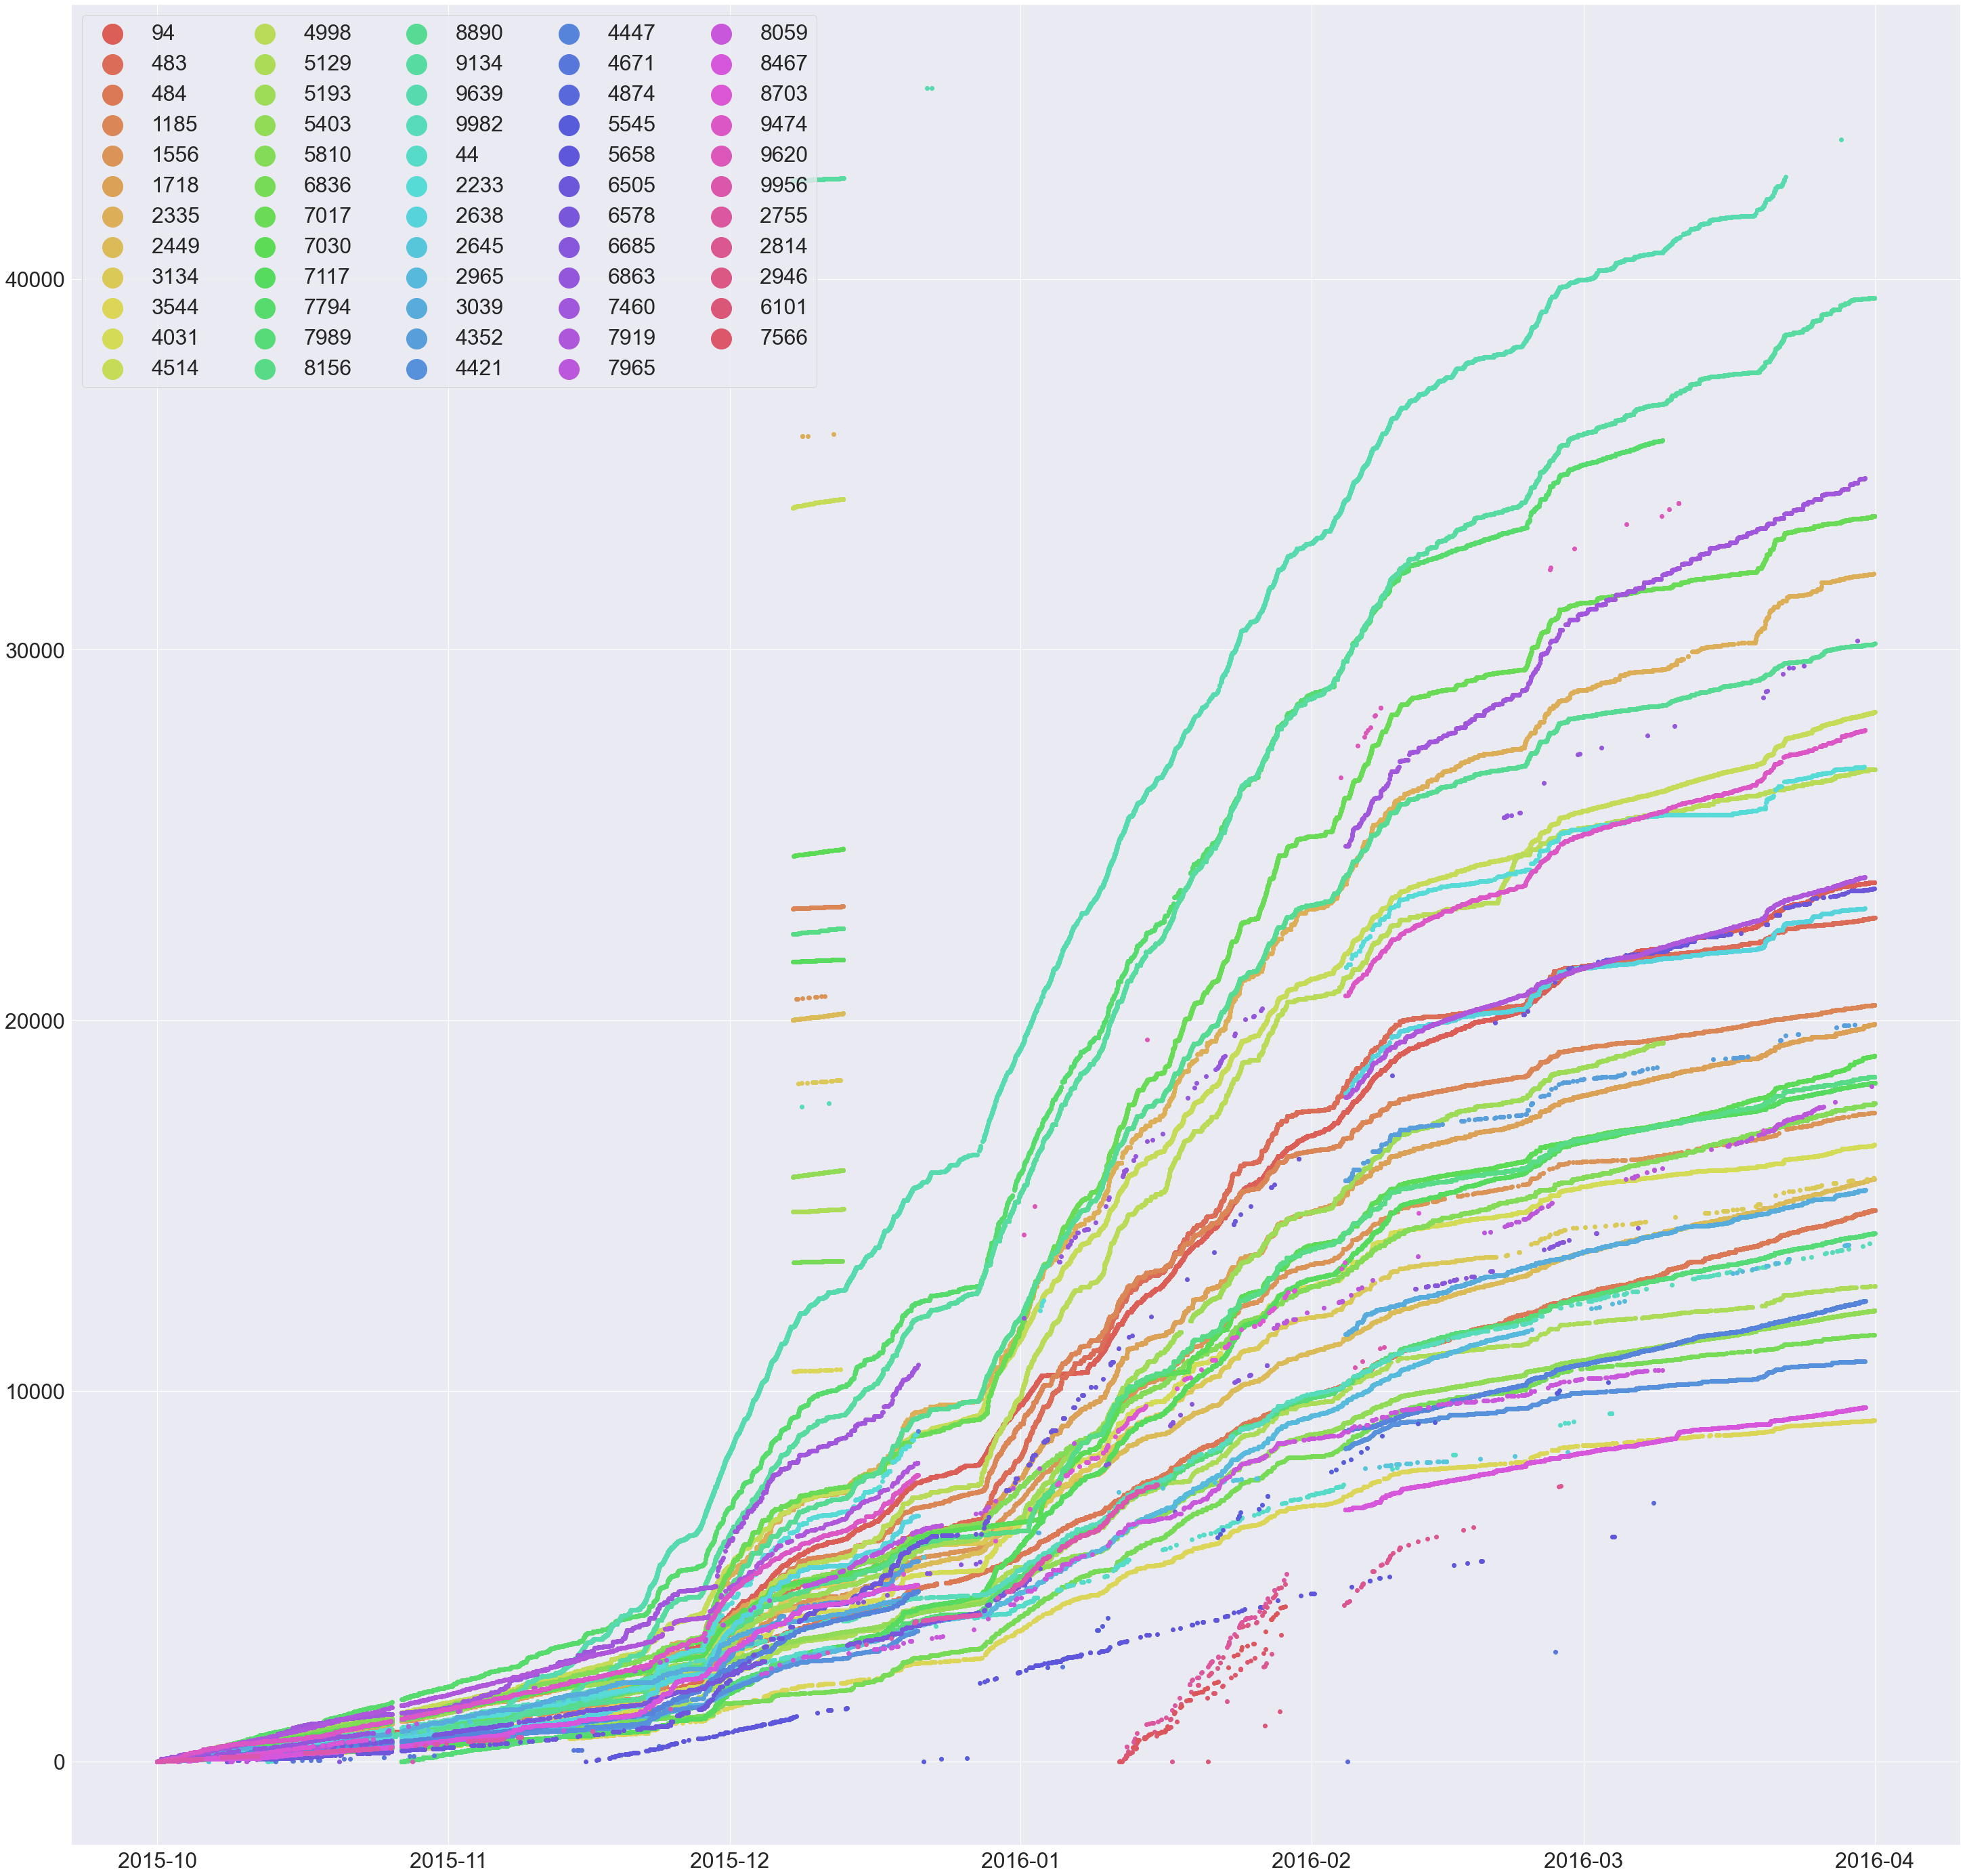

In [ ]:
sns.set_palette(sns.color_palette("hls", len(malfunction)))
outliers=list(malfunction)
plt.subplots(figsize=(50,50))
for house in outliers:
    new_value = group_df.get_group(house).meter_value.values - group_df.get_group(house).meter_value.values[0]

    plt.legend(list(malfunction), ncol=5, loc='best',fontsize = 32, markerscale = 5);
    plt.scatter(group_df.get_group(house).localminute.values, new_value)
    plt.xticks(fontsize = 32)### Results 
#As such, we will plot the malfunctioning meters all in one graph
    plt.yticks(fontsize = 32)

# Question 1.2
- Generate hourly reading
- Plotting one month of meter readings for all meters

## Step 1 
The malfunctioning meters were identified in Question 1.1, as it is not deterministic if the malfunctioning meters are "fixed". The following analysis will exclude the malfunction meters from 1.1(a), 1.1(c) and 1.1(d). 

Note: malfunctioning meters 1.1(b) is included for Q1.2 analysis as we are able to interpolate the data for the missing days. As well as observe that the data in 1.1(b) just have missing data, rather than acting as a malfunctioning meter.  

In [ ]:
malfunction_remove = {**malfunction_sudden_increase, **malfunction_meter_decrease,**malfunction_little_readings} 
print(list(malfunction_remove.keys()))
print(f'Number of malfunction meters removed: {len(malfunction_remove)}')


[2449, 3134, 3544, 4514, 5403, 6836, 7030, 8156, 9134, 94, 483, 484, 1185, 1556, 1718, 2335, 4031, 4998, 5129, 5193, 5810, 7017, 7117, 7794, 7989, 8890, 9639, 9982, 2645, 2755, 2814, 2946, 4671, 4874, 5545, 6101, 6685, 7566, 9160, 9620]
Number of malfunction meters removed: 40


In [ ]:
#Keeping the functional meters and remove the malfunctioning meters
no_malfunction = df[np.logical_not(df["dataid"].isin(malfunction_remove))] 
house_ID = no_malfunction["dataid"].unique()
print(f'Number of functional meter left: {len(house_ID)}')
print(house_ID)

Number of functional meter left: 117
[ 739 6910 3635 1507 4352 1714 9849 5131 6412 7429  871 1086 1589 9631
 4447 2034 5275 7287 4296  252 8829 3039 9121 7741 7919 7674 4732  370
 9295 3577  222   35 1697 4767 5785 7739 3367 8467 5972 5439  114 9474
 7460 9278 2018 9052 9956 8155 5636 4029 1791 1801 9729 1283 1792 3893
 7682 2638  187 3723 5814   77 1619 4421  661 1042 4373 5484 2072 2461
  744 1790 1800 2980 2094 5892 7900 8084 3527 3849 4356 2129 2965 2575
 8086 1415 2233 6863 2470 3778 2378 6830 9766 4193 8703 6578 4228 6505
 5395 8059 7965   44 2945 2818 7016 8967 3310 3918 8386 1103 5658 5317
 3036 8244 9600 1403 6673]


## Step 2
Plot the hourly data over the 6 months.

First, we will convert the data to minute and interpolate based on the mean values. 

Then we will convert the data into hourly readings. 

<ipython-input-24-8c6123cc430e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['meter_value'] = tmp_df['meter_value'] - group_no_malfunction.get_group(household).meter_value.iloc[0]
<ipython-input-24-8c6123cc430e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['localminute'] = pd.to_datetime(tmp_df['localminute'],utc = True)


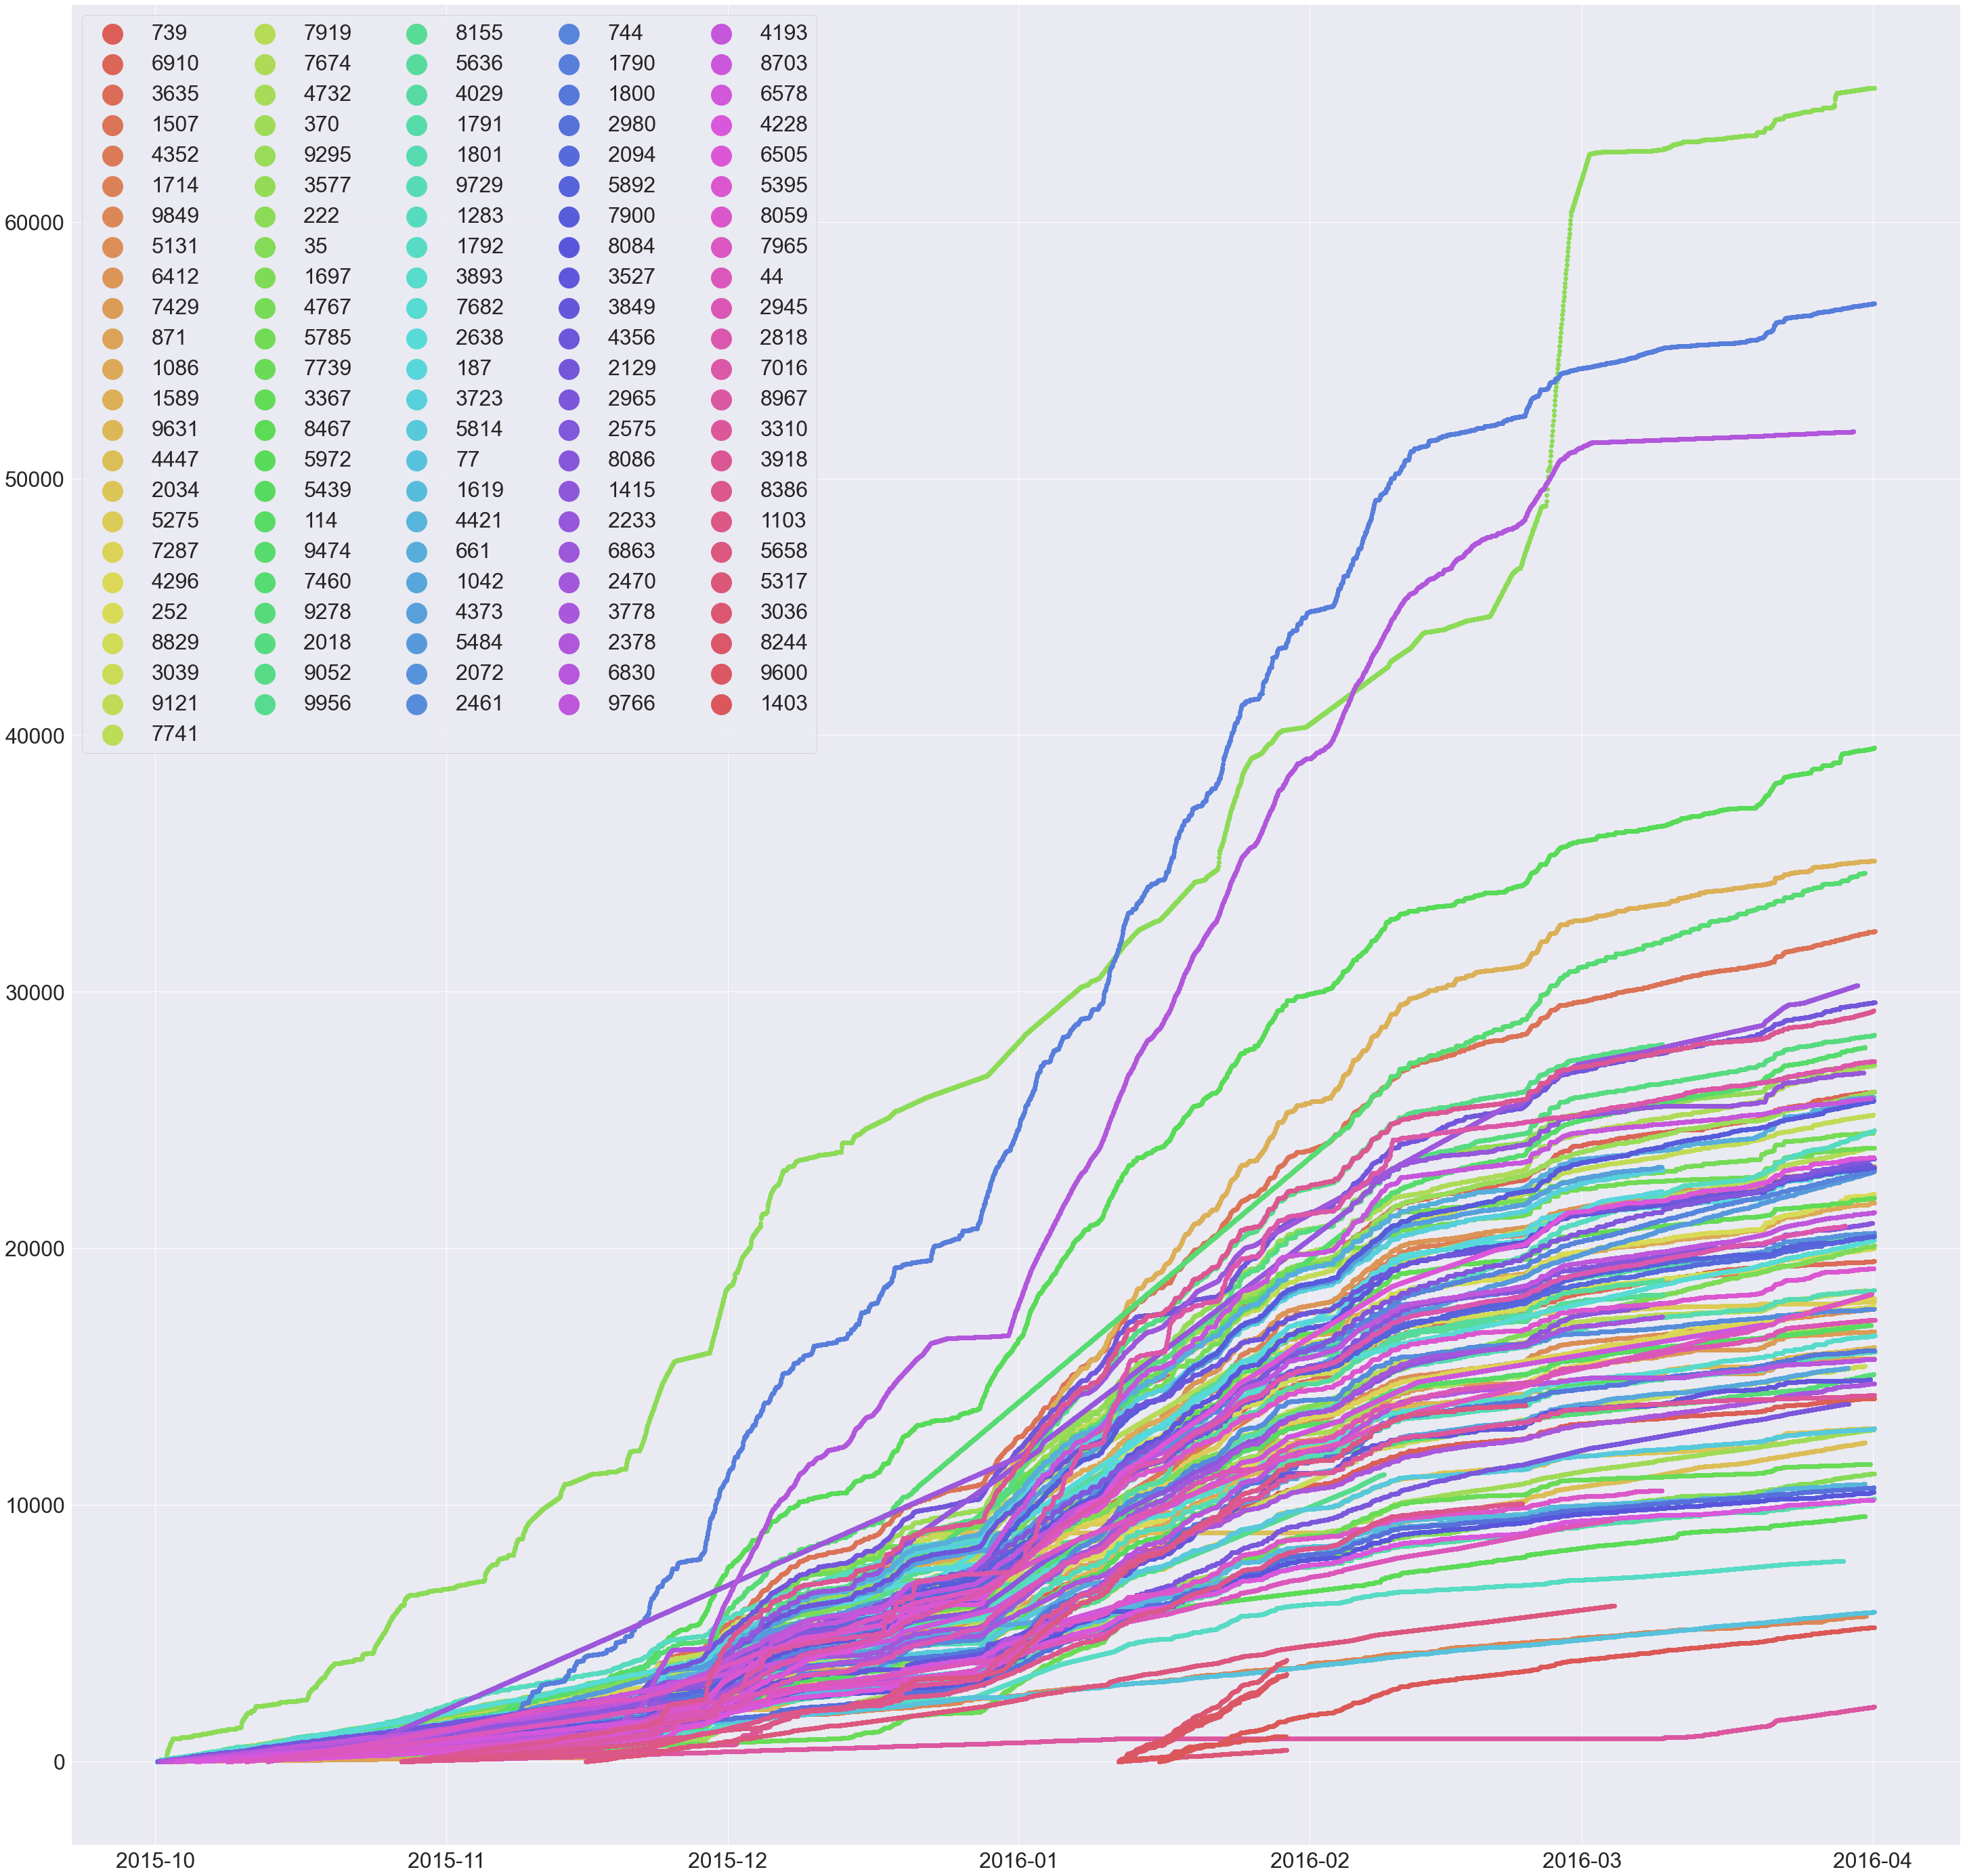

In [ ]:
sns.set_palette(sns.color_palette("hls", len(house_ID)))
plt.subplots(figsize=(50,50))
hourly_data = {}
group_no_malfunction=no_malfunction.groupby('dataid')

for household in house_ID:
    tmp_df = group_no_malfunction.get_group(household)
    tmp_df['meter_value'] = tmp_df['meter_value'] - group_no_malfunction.get_group(household).meter_value.iloc[0]
    tmp_df['localminute'] = pd.to_datetime(tmp_df['localminute'],utc = True)
    tmp = tmp_df.resample('min', on='localminute',label='right').mean().interpolate(method='linear')
    hourly_data[household] = tmp.resample('H').mean().interpolate(method = 'linear')
    temp_hour = pd.DataFrame (hourly_data[household])

    plt.legend(house_ID, ncol=5, loc='best',fontsize = 32, markerscale = 5);
    plt.scatter(temp_hour.index, temp_hour.values[:,1])
    plt.xticks(fontsize = 32)
    plt.yticks(fontsize = 32)
    

## Step 3
As we included section 1.1(b), which has data missing for over 10 days.
To ensure that there are no missing data, we will be using bfill and ffill, filling the missing values in the dataset using both the backward and forward methods. 

In [ ]:
hourly_data_df = pd.DataFrame()
for key in hourly_data:
    frame = [hourly_data_df, hourly_data[key]]
    hourly_data_df = pd.concat(frame, axis=1)
    
hourly_data_df.drop(["dataid"], axis = 1, inplace = True)
hourly_data_df.columns = hourly_data.keys()
hourly_data_df = hourly_data_df.fillna(method='bfill')
hourly_data_df = hourly_data_df.fillna(method='ffill')


### Pick a random month to plot the hourly data -> December 2015 
We have picked December 2015 out of the 6 calendar months 

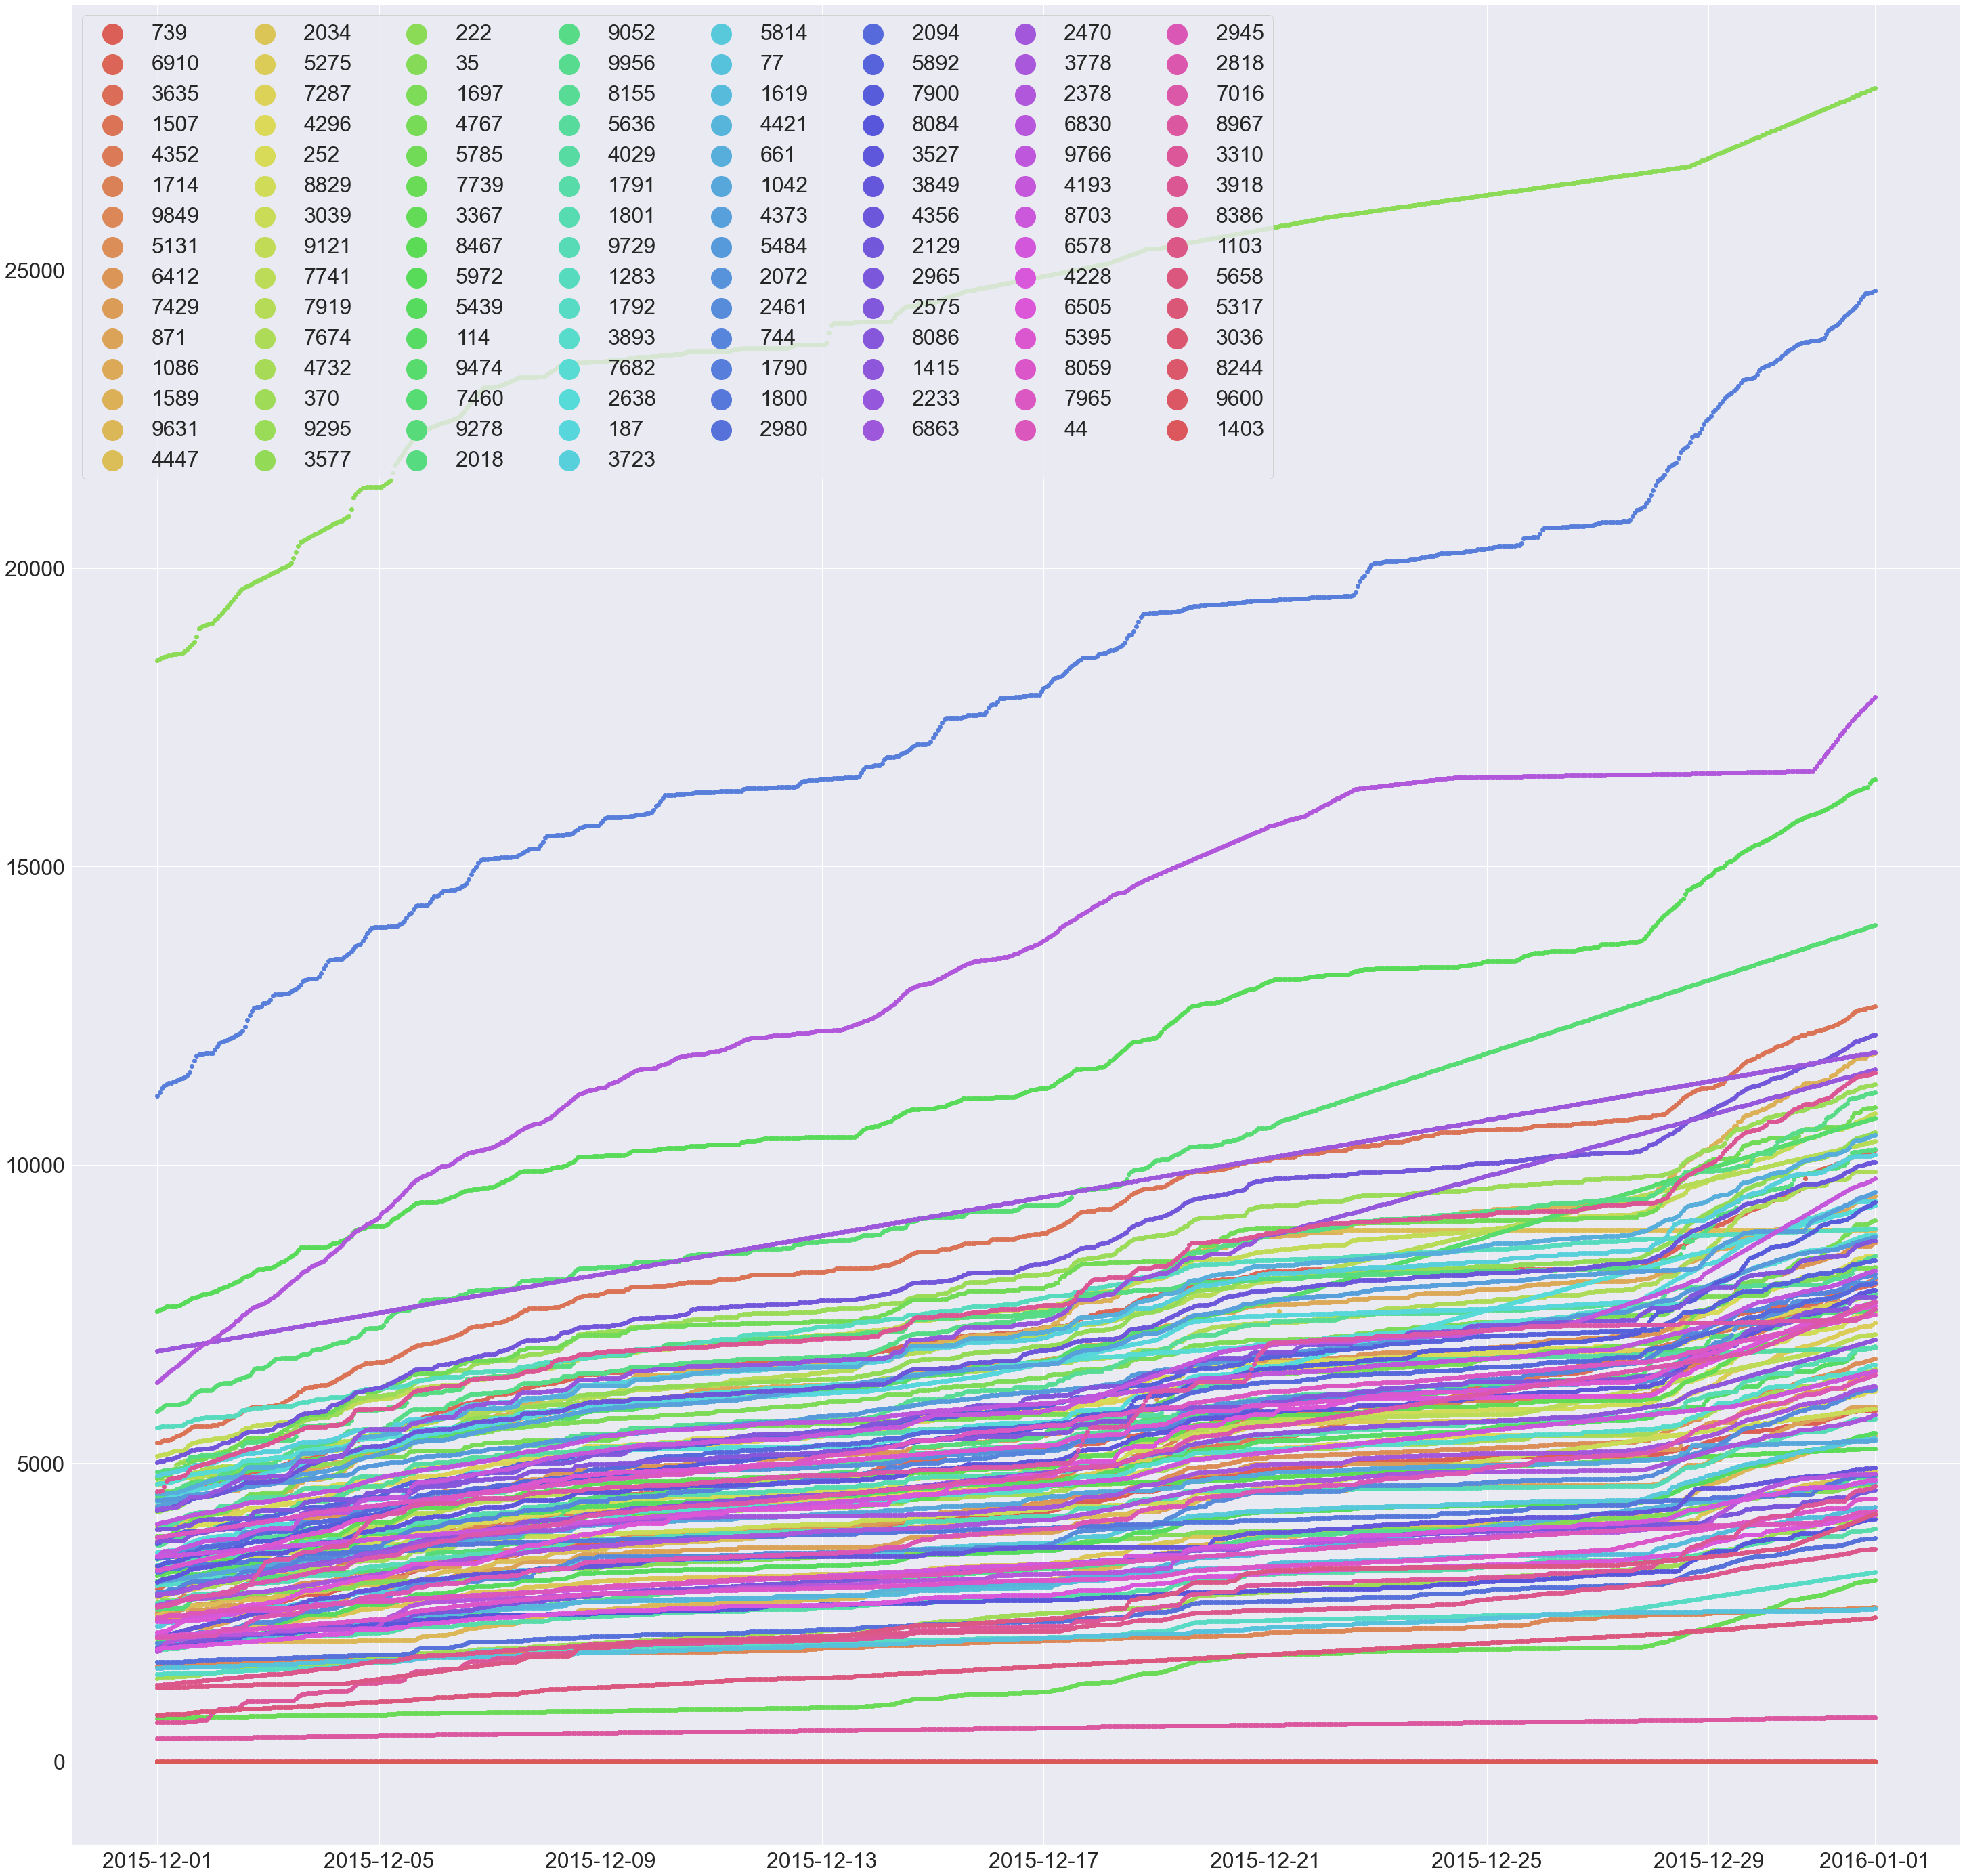

In [ ]:
sns.set_palette(sns.color_palette("hls", 117))
Dec_hourly_data = hourly_data_df.loc['2015-12-01 00:00:00':'2016-01-01 00:00:00']
plt.subplots(figsize=(50,50))
for ID in house_ID:
    plt.legend(house_ID, ncol=8, loc='best',fontsize = 32, markerscale = 5)
    plt.scatter(Dec_hourly_data[ID].index, Dec_hourly_data[ID].values)
    plt.xticks(fontsize = 32)
    plt.yticks(fontsize = 32)

# Question 1.3
 - For each home, ﬁnd the top ﬁve homes with which it shows the highest correlation.
 - We will be finding both the highest correlation and lowest correlation for a visible relation in the graph. 

### What is correlation?
Correlation: shows the mutual relationship between two or more things. 
The magnitude of the correlation indicate the strength of the relationship of the two datas. 
The value of correlation coefficient ranges from -1 and +1. 
- -1: Perfect negative correlation 
 -  The graph move in opposite directions 
- +1: Perfect positive correlation
 -  The graph moves in the same direction, and in a almost similar trend


In [ ]:
correlation = hourly_data_df.corr()
lowest_correlation_meter = {}
correlation.reset_index()
top_correlation_meter = {}

for ID in house_ID:
    top_correlation_meter[ID] = correlation.loc[ID].sort_values(ascending = False).index[1:6]
    lowest_correlation_meter[ID] = correlation.loc[ID].sort_values(ascending = False).index[-5:]
top_correlation_meter = pd.DataFrame(top_correlation_meter)
lowest_correlation_meter = pd.DataFrame(lowest_correlation_meter)

###  Top 5 homes with the highest correlated houses for each home

In [ ]:
top_correlation_meter

739   6910  3635  1507  4352  1714  9849  5131  6412  7429  ...  3918  \
0  5814  1507  5814  2094  2638  1589    77  4352  8829  8829  ...  5395   
1   661  2094   661  6910  5131  3527  7965  2818  3367  2034  ...  3577   
2  9295  4732  3577  7741  2818  3367  1697  8829  2034  7741  ...   252   
3  4421  4228  4356  5892  8829  9631    35  2638  7429  4732  ...  5814   
4  5395  1801  2233  1801  7429  6412  6863  4732  2072  9729  ...   871   

   8386  1103  5658  5317  3036  8244  9600  1403  6673  
0  5439  8386  2378  9600  9600  3036  3036  9600  8244  
1  1103  3310  5131  3036  8244  9600  5317  5317  2965  
2  2461  7016  2818  8244  5317  5317  8244  3036  3036  
3  2470  6830  2638  1403  1403  1403  1403  8244  9600  
4  5275  2461  4352  7739  7739  7739  7739  7739  5317  

[5 rows x 117 columns]

###  Top 5 homes with the lowest correlated houses for each home

In [ ]:
lowest_correlation_meter

739   6910  3635  1507  4352  1714  9849  5131  6412  7429  ...  3918  \
0  3036  3036  3036  3036  3036  8244  9600  3036  3036  3036  ...  1403   
1  1403  1403  1403  1403  1403  6578  3036  8244  1403  1403  ...  3036   
2  8244  8244  8244  8244  8244  4447  8244  1403  8244  8244  ...  8244   
3  8967  8967  8967  8967  6673  6673  1403  6673  6673  6673  ...  8967   
4  6673  6673  6673  6673  8967  8967  6673  8967  8967  8967  ...  6673   

   8386  1103  5658  5317  3036  8244  9600  1403  6673  
0  6578  8467  3036   222   222   222   222   222  8155  
1  8244  6578  8244  8467  8467  8467  8467  8467  8467  
2  4447  4447  1403  6578  6578  6578  6578  6578  8967  
3  6673  6673  6673  4447  4447  4447  4447  4447  4447  
4  8967  8967  8967  8967  8967  8967  8967  8967  6578  

[5 rows x 117 columns]

### Looking at home 3918, the 5 homes 5395, 3577, 252, 5814 and 871 has the highest correlation. 

### Plotting 3918 and 5395 
The first plot showcase the highest correlation between house ID 3918 and 5395 in terms of raw data, over the 6 months. Follow by the plot that showcase the highest correlation between house ID 3918 and 5395 in terms of the interpolated data using hourly data.


### Looking at home 3918, the 5 homes 1403, 3036, 8244, 8967 and 6673 has the lowest correlation. 

### Plotting 3918 and 1403 
The third plot showcase the lowest correlation between house ID 3918 and 1403 in terms of raw data, over the 6 months. Follow by the plot that showcase the lowest correlation between house ID 3918 and 1403 in terms of the interpolated data using hourly data.

#### Plotting 3918 and 5395 - High Correlation Raw Data

Text(0.5, 1.0, 'High Correlation Raw Data')

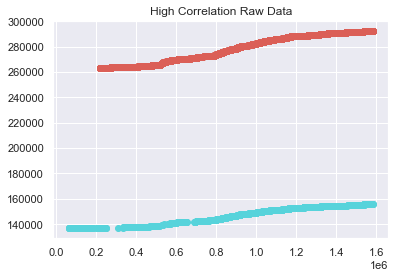

In [ ]:
sns.set_palette(sns.color_palette("hls", 2))
plt.scatter(group_no_malfunction.get_group(3918).index, 
            group_no_malfunction.get_group(3918).meter_value)
plt.scatter(group_no_malfunction.get_group(5395).index, 
            group_no_malfunction.get_group(5395).meter_value)
plt.title("High Correlation Raw Data")


#### Plotting 3918 and 5395 - High Correlation Interpolated Hourly Data

Text(0.5, 1.0, 'High Correlation Interpolated Hourly Data')

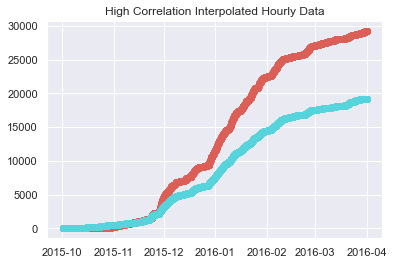

In [ ]:
sns.set_palette(sns.color_palette("hls", 2))
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,3918].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,5395].values)
plt.title("High Correlation Interpolated Hourly Data")

#### Plotting 3918 and 1403 - Low Correlation Raw Data

Text(0.5, 1.0, 'Low Correlation Raw Data')

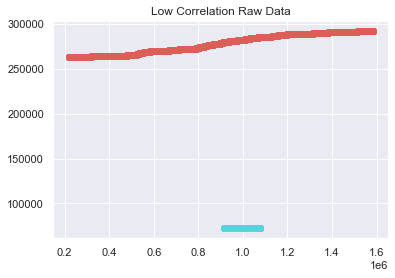

In [ ]:
sns.set_palette(sns.color_palette("hls", 2))
plt.scatter(group_no_malfunction.get_group(3918).index, 
            group_no_malfunction.get_group(3918).meter_value)
plt.scatter(group_no_malfunction.get_group(1403).index, 
            group_no_malfunction.get_group(1403).meter_value)
plt.title("Low Correlation Raw Data")

#### Plotting 3918 and 1403 - Low Correlation Interpolated Hourly Data

Text(0.5, 1.0, 'Low correlation of Interpolated hourly data')

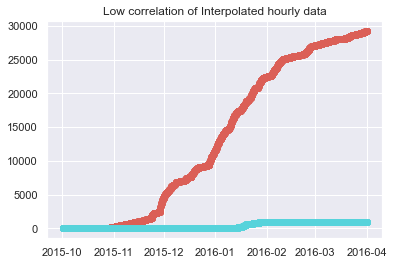

In [ ]:
sns.set_palette(sns.color_palette("hls", 2))
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,3918].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,1403].values)
plt.title("Low correlation of Interpolated hourly data")

### Plotting 3918 against the top 5 homes 5395, 3577, 252, 5814 and 871 with the highest correlation. 

Text(0.5, 1.0, 'High correlation hourly data for 3918')

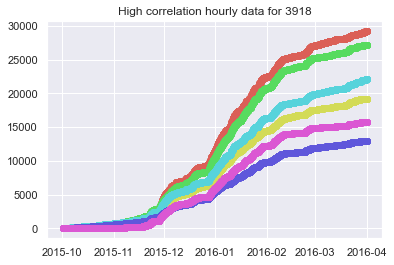

In [ ]:
sns.set_palette(sns.color_palette("hls", 6))
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,3918].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,5395].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,3577].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,252].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,5814].values)
plt.scatter(hourly_data_df.index, hourly_data_df.loc[:,871].values)
plt.title("High correlation hourly data for 3918")

# Question 2.1
In this part, you will asked to build a model to forecast the hourly readings in the future (next hour). Can you explain why you may want to forecast the gas consumption in the future? Who would find this information valuable? What can you do if you have a good forecasting model?

Firstly, the ability to forecast the gas consumption accurately allows gas company to predicted the trend of the consumption so that gas company are able to strategize their corresponding marketing strategies, business decisions and operation cost effectively.

Other than that, the forecasted gas consumption data allows natural gas supplier company to effectively make the decision of storing or supplying sufficent amount of natural gas for each area without oversupplying. In addition, the company is able to detect areas that has potential significant decrease in consumption of their natural gas; Consequently, they can strategize their marketing strategy in that area such as increase the advertisement activity to increase the sales. Furthermore, with forecasting the company is able to supply sufficient amount of natural gas based on the trend to maximize their profit because overproduction or under production is not healthy to their business.

Moreover, economists can use the forecasted consumption to assist them in analysing the consumer market; Hence, they are able to make better prediction of the consumer market's trend and plan business strategy accordingly. Lastly, with a good forecasting model, stock traders are able to predict the period for selling and buying on the gas industry stock market as they are able to know when is the period of low consumption and period of high consumption. 






# Question 2.2 
Build a linear regression model to forecast the hourly readings in the future (next hour). 
Generate two plots:
- (i) Time series plot of the actual and predicted hourly meter readings and
- (ii) Scatter plot of actual vs predicted meter readings (along with the line showing how good the fit is).

In [ ]:
# Functions for Prediction
sns.set_palette(sns.color_palette("hls", 5))
def get_int_datetime(date_type):
    datetime64 = date_type.astype('datetime64[h]')
    int_datetime64 = datetime64.astype(int)
    return int_datetime64

def preprocessed_data(id):
    train_sample = pd.DataFrame(hourly_data_df.iloc[:][id].values)
    dataset_size = len(train_sample)
    train_size = math.trunc(0.8 * dataset_size)
    date = hourly_data_df.index
    train_date = (date[:train_size][:, None]).astype('datetime64[h]')
    test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')
    train_data_duplicate = train_sample.iloc[:train_size]
    test_data_duplicate = train_sample.iloc[train_size:]
    train_data = train_sample.iloc[:train_size]
    test_data = train_sample.iloc[train_size:]
    new_date_range = np.array(list(pd.date_range('2016-04-01T05', periods=2200, freq='H')), dtype='datetime64')[:, None].astype("datetime64[h]")
    
    return train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate

# linear reg instantiation
def lr_predictor(lr_module):
    lr_module.fit(train_date,train_data)
    y_pred = lr_module.predict(get_int_datetime(test_date))
    y_pred_forecast = lr_module.predict(new_date_range.astype(int))    
    return y_pred, test_data, y_pred_forecast, lr_module

def plot(lr_module_name, y_pred_forecast, ID):
    plt.subplots(figsize=(20,15))
    np_train_date = np.array(train_date)
    np_test_data = np.array(test_data)
    np_train_data = np.array(train_data)
    np_test_date = np.array(test_date)
    plt.plot(np_train_date, np_train_data)
    plt.plot(np_test_date, np_test_data)
    plt.plot(train_date, lr_module_name.predict(get_int_datetime(train_date)))
    plt.plot(test_date, lr_module_name.predict(get_int_datetime(test_date)))
    plt.plot(new_date_range, y_pred_forecast)

    
def scatter(lr_module_name, y_pred_forecast, ID):
    plt.subplots(figsize=(20,15))
    plt.scatter(train_date, train_data)
    plt.scatter(test_date, test_data)
    plt.scatter(train_date, lr_module_name.predict(get_int_datetime(train_date)))
    plt.scatter(test_date, lr_module_name.predict(get_int_datetime(test_date)))
    plt.scatter(new_date_range, y_pred_forecast)


def show(ID):
    plt.title(f"Meter Read: {ID} , Plot of Gas Consumption against Time using Linear Regression", fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Gas Consumption', fontsize=25)
    plt.legend(['Train Data', 'Test Data', 'Best Fit Train Line', "Best Fit Test Line",'Prediction'], fontsize=25)
    plt.xticks(fontsize=25)
    plt.show()

## Plot for Meter 9849 using Linear Regression Model

<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The mean square error of the Linear Regression Model on Test Data is 10256.933907456656

Visualizing the relationship using Time Series with Line plot:



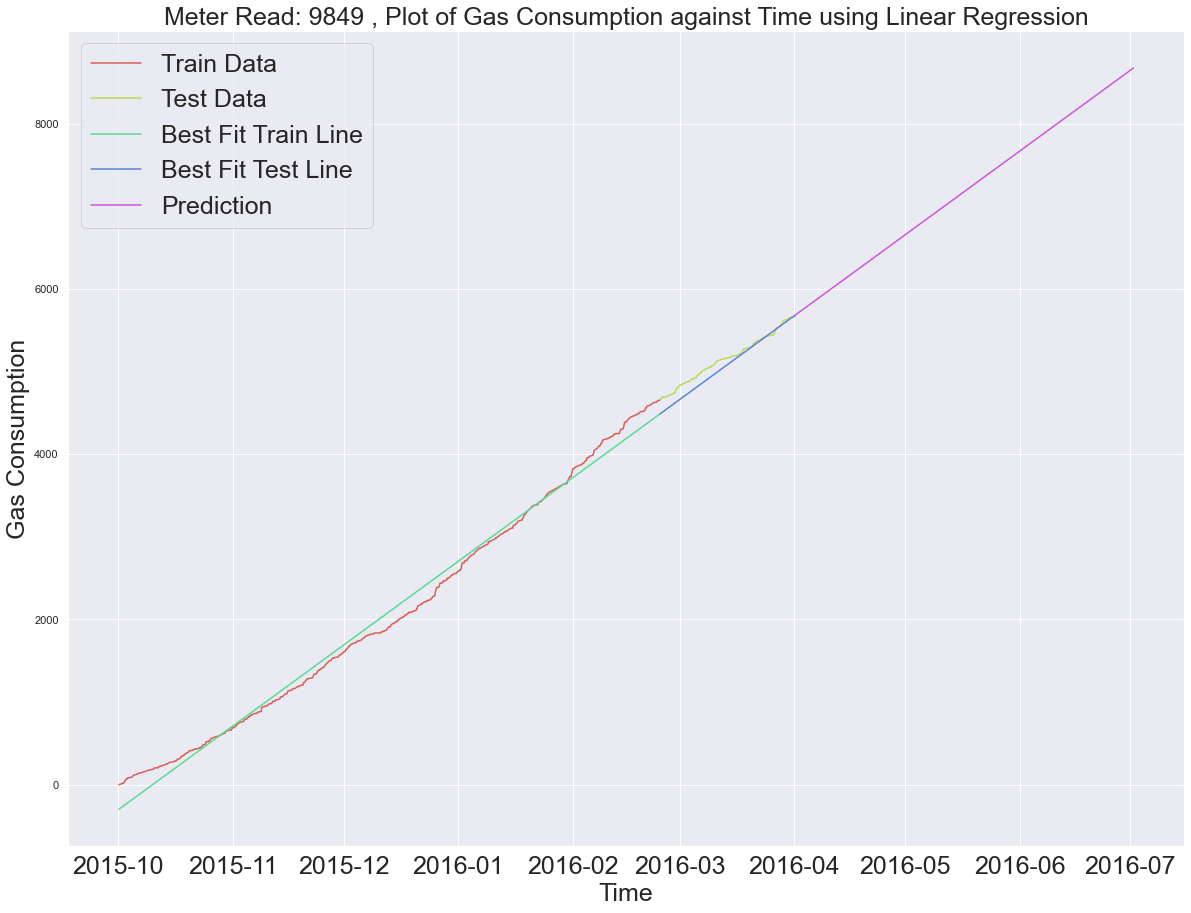

Visualizing the relationship using Scatter plot:



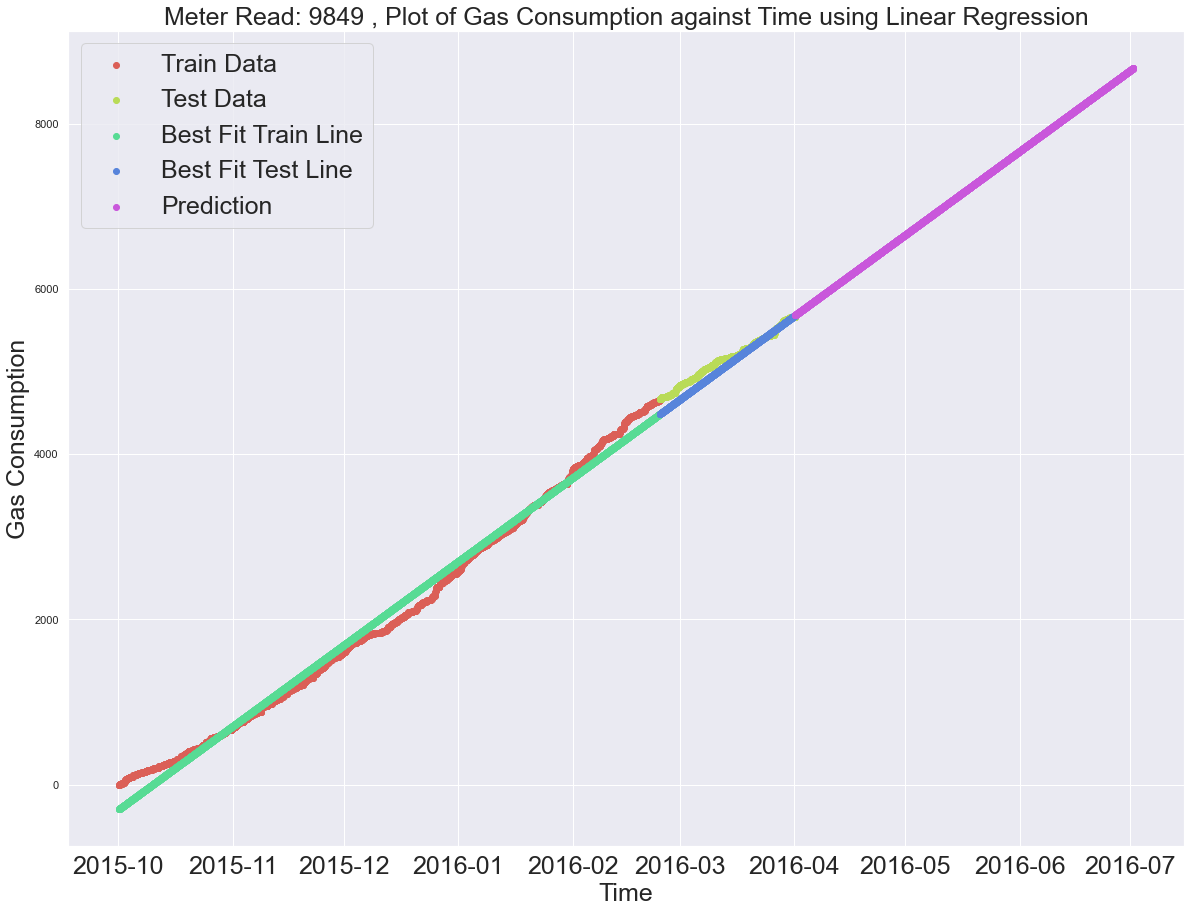

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(9849) 
y_pred,test_data,y_pred_forecast,lr_9849 = lr_predictor(lm.LinearRegression())
print(f"The mean square error of the Linear Regression Model on Test Data is {mean_squared_error(y_pred, test_data)}\n")
print('Visualizing the relationship using Time Series with Line plot:\n')
plot(lr_9849, y_pred_forecast, 9849)
show(9849)

print('Visualizing the relationship using Scatter plot:\n')
scatter(lr_9849, y_pred_forecast, 9849)
show(9849)

## Plot for Meter 77 using Linear Regression Model

<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The mean square error of the Linear Regression Model on Test Data is 38148.16788138242

Visualizing the relationship using Time Series with Line plot:



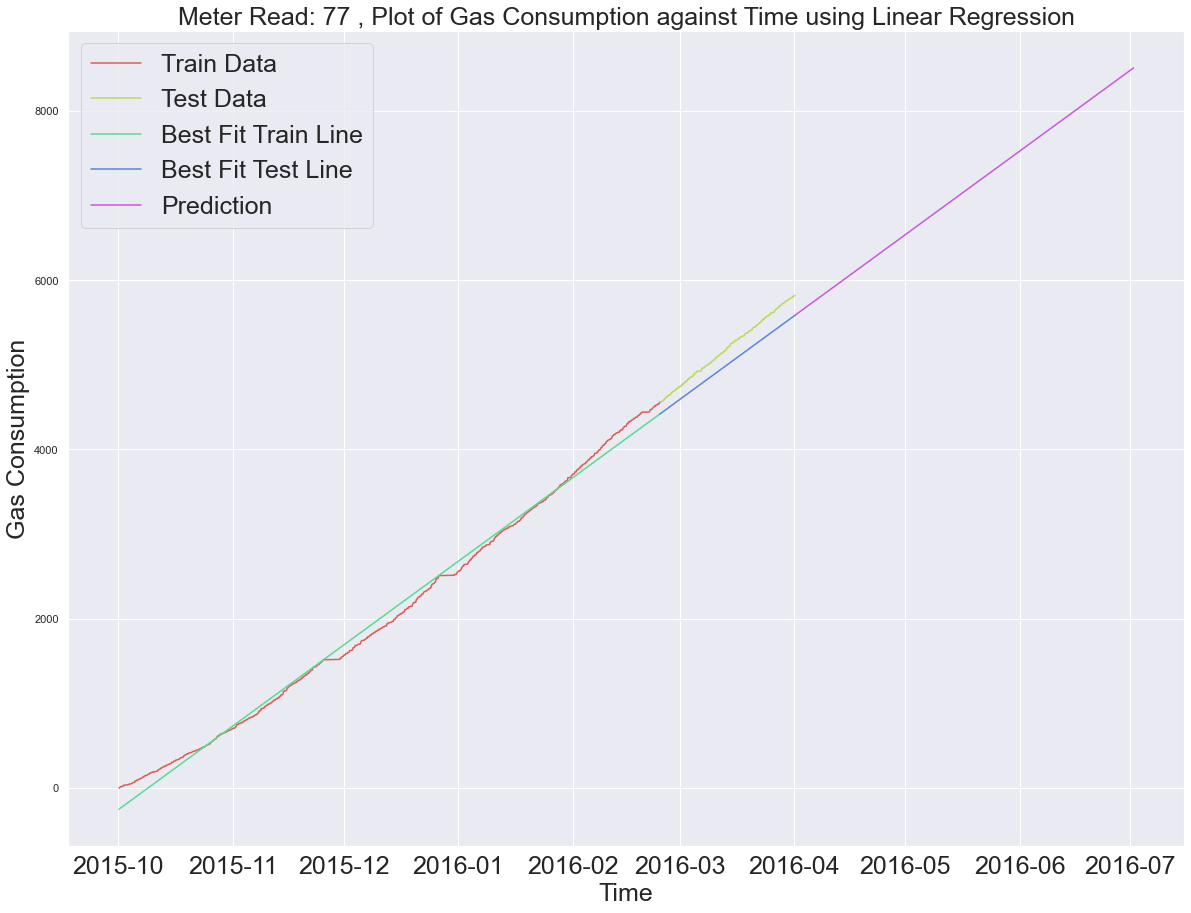

Visualizing the relationship using Scatter plot:



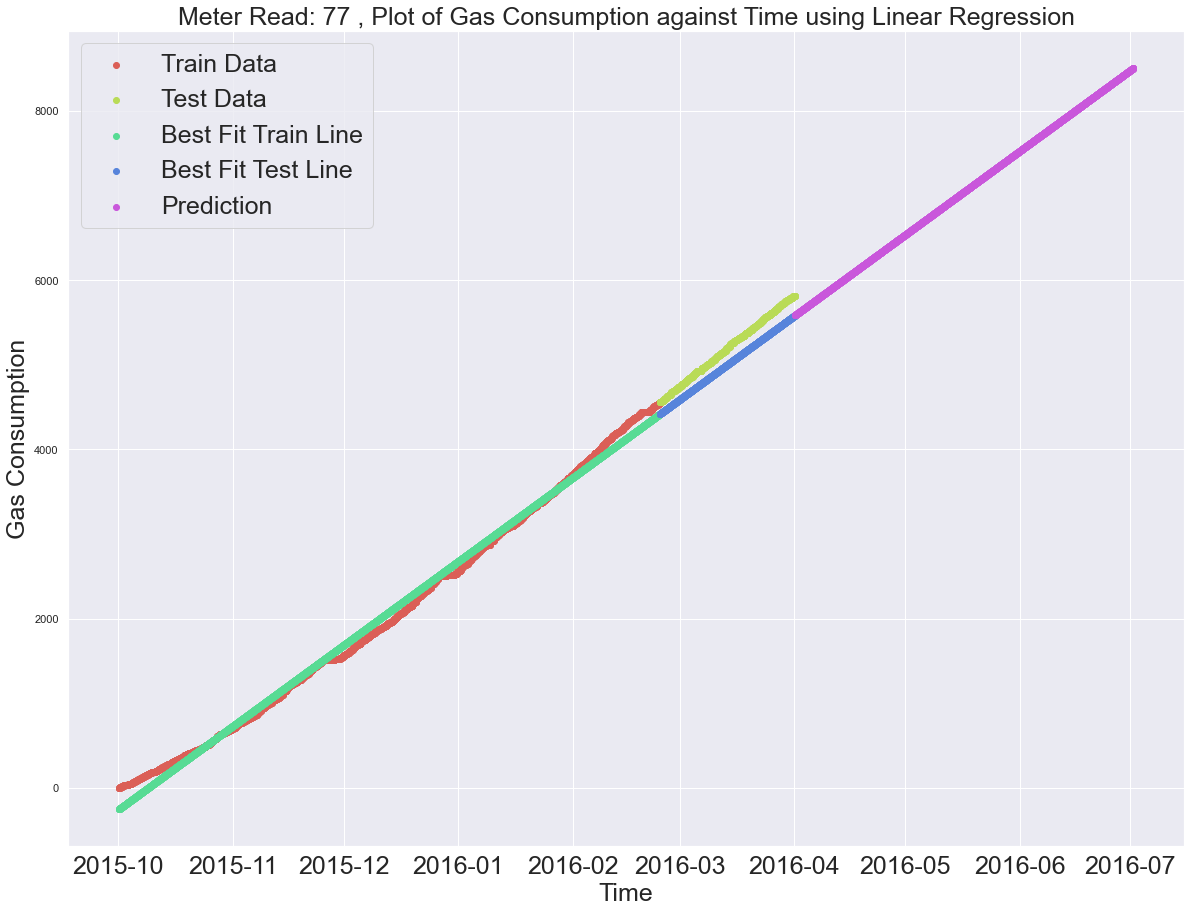

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(77)
y_pred,test_data,y_pred_forecast,lr_77 = lr_predictor(lm.LinearRegression())
print(f"The mean square error of the Linear Regression Model on Test Data is {mean_squared_error(y_pred, test_data)}\n")
print('Visualizing the relationship using Time Series with Line plot:\n')
plot(lr_77, y_pred_forecast, 77)
show(77)

print('Visualizing the relationship using Scatter plot:\n')
scatter(lr_77, y_pred_forecast, 77)
show(77)

## Plot for Meter 35 using Linear Regression Model

<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The mean square error of the Linear Regression Model on Test Data is 81775.87223588936

Visualizing the relationship using Time Series with Line plot:



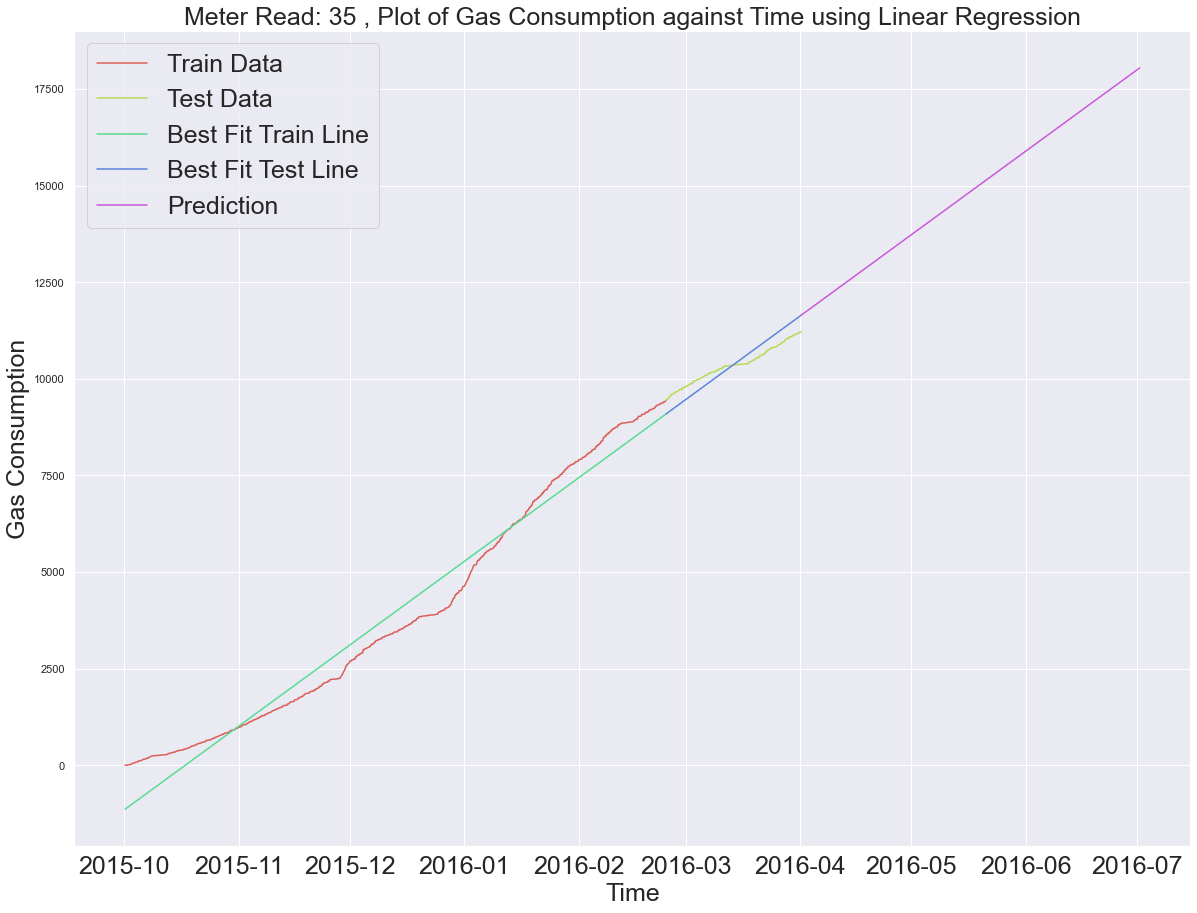

Visualizing the relationship using Scatter plot:



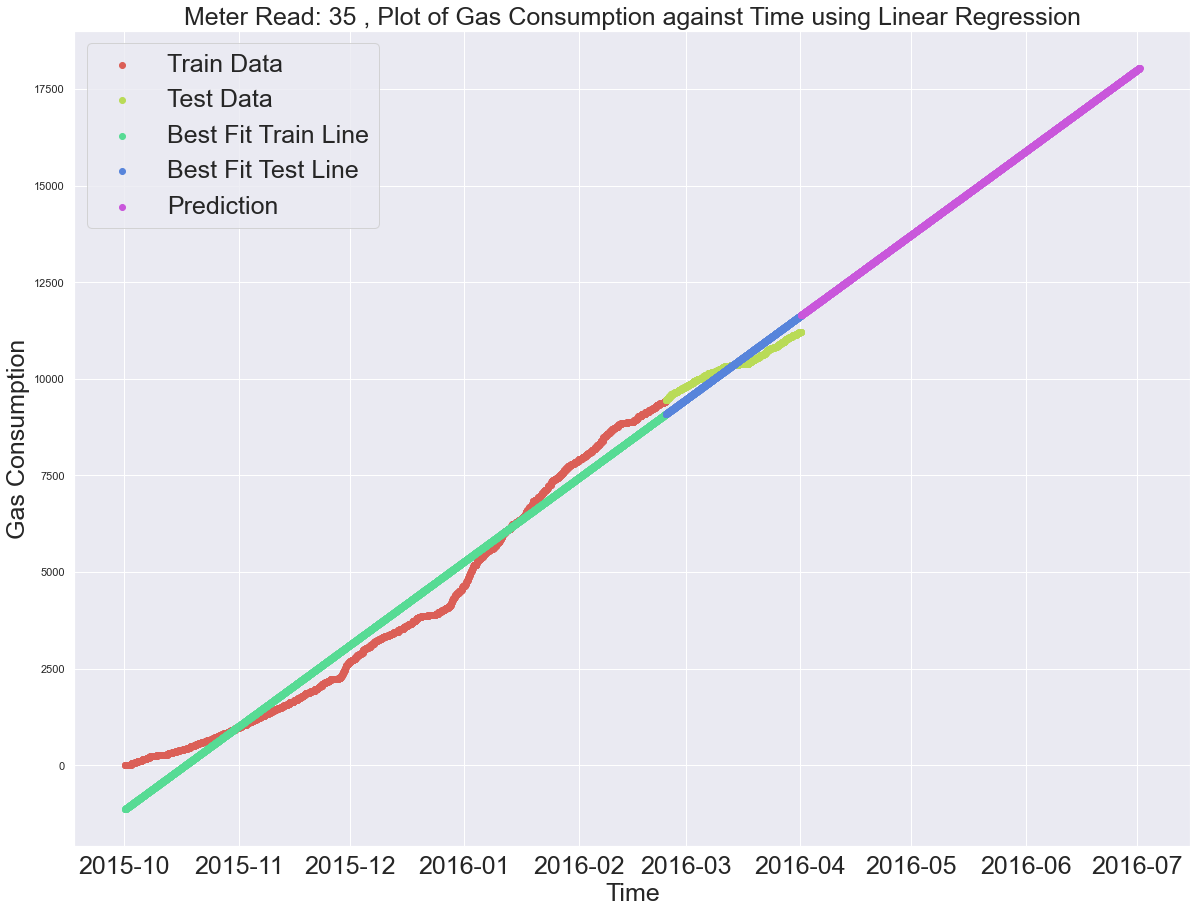

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(35)
y_pred, test_data, y_pred_forecast, lr_35 = lr_predictor(lm.LinearRegression())
print(f"The mean square error of the Linear Regression Model on Test Data is {mean_squared_error(y_pred, test_data)}\n")
print('Visualizing the relationship using Time Series with Line plot:\n')
plot(lr_35, y_pred_forecast, 35)
show(35)
print('Visualizing the relationship using Scatter plot:\n')
scatter(lr_35, y_pred_forecast, 35)
show(35)

# Question 2.3
Do the same as Question 2.2 above but use support vector regression (SVR).

Build a Support Vector Regression model to forecast the hourly readings in the future (next hour). 
Generate two plots:
- (i) Time series plot of the actual and predicted hourly meter readings and
- (ii) Scatter plot of actual vs predicted meter readings (along with the line showing how good the fit is).

In [ ]:
sns.set_palette(sns.color_palette("hls", 5))
def fit_data_in_range(data):
    return MinMaxScaler(feature_range = (False, True)).fit(data)

def scaler_transform_data(type_of_data):
    data_size = len(type_of_data)
    return scaler.transform(type_of_data).reshape(data_size, 1)

def scaler_inverse_transform_data(type_of_prediction):
    data_size = len(type_of_prediction)
    return scaler.inverse_transform(type_of_prediction.reshape(data_size, 1))

def parameter_dict(C_range, gamma_range):
    keys = ["kernel", "C", "gamma"]
    values = [["rbf"], C_range, gamma_range]
    if gamma_range is None:
        keys, values = keys[:2], [["linear"], C_range]
    return dict(zip(keys, values))

def svr(svr_module_name, train_date, test_date, train_input):
    model = svr_module_name.fit(train_date,train_input)
    train_predict = model.predict(train_date)
    test_predict = model.predict(test_date)
    forecast_data = svr_module_name.predict(new_date_range.astype(int))
    return train_predict, test_predict, svr_module_name, forecast_data

def plot_scatter_svr(ID, train_predict, test_predict, future_predict_data, kernel):
    plt.subplots(figsize=(20, 15))
    plt.scatter(np.array(train_date), np.array(train_data_duplicate))
    plt.scatter(np.array(test_date), np.array(test_data_duplicate), label = 'Test Data')
    plt.scatter(np.array(train_date), np.array(train_predict), label = 'Predicted Train Data')    
    plt.scatter(np.array(test_date), np.array(test_predict), label = 'Predicted Test Data')
    plt.scatter(np.array(new_date_range), np.array(future_predict_data))
    
def plot_line_svr(ID, train_predict, test_predict, future_predict_data, kernel):
    plt.subplots(figsize=(20,15))
    plt.plot(np.array(train_date), np.array(train_data_duplicate))
    plt.plot(np.array(test_date),np.array(test_data_duplicate),label = 'Test Data')
    plt.plot(np.array(train_date),np.array(train_predict),label = 'Predicted Train Data')    
    plt.plot(np.array(test_date),np.array(test_predict),label = 'Predicted Test Data')
    plt.plot(np.array(new_date_range), np.array(future_predict_data))

def show2(ID, kernel_type):
    plt.title(f"Meter Read: {ID}, Plot of Gas Consumption against Time using {kernel_type} kernel SVR",fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Gas Consumption', fontsize=25)
    plt.legend(['Train Data', 'Test Data', 'Best Fit Train Line', "Best Fit Test Line",'Prediction'], fontsize=25)
    plt.xticks(fontsize=25)
    plt.show()

## Plot for Meter 9849 using Linear SVR Model 
### SVR Actual vs the Fit Line. 
Forecasting and using GridSearch method to find the optimal value for the hyperparameter C for linear kernel SVR

In [ ]:
# Defining variables 

C_range = np.logspace(-4, 5, 10)
gamma_range = None

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(9849)
scaler = fit_data_in_range(train_data)
train_data = scaler_transform_data(train_data)
test_data = scaler_transform_data(test_data)
train_input=train_data.ravel()

parameters = parameter_dict(C_range, gamma_range)

grid = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', n_jobs = 6)
grid.fit(train_date, train_data.ravel())
print(f"The best parameters from GridSearch are {grid.best_params_}")

The best parameters from GridSearch are {'C': 0.0001, 'kernel': 'linear'}


<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The mean square error of the linear SVR on Test Data is 215114.21625139003

Visualizing the relationship using Time Series with Line plot:



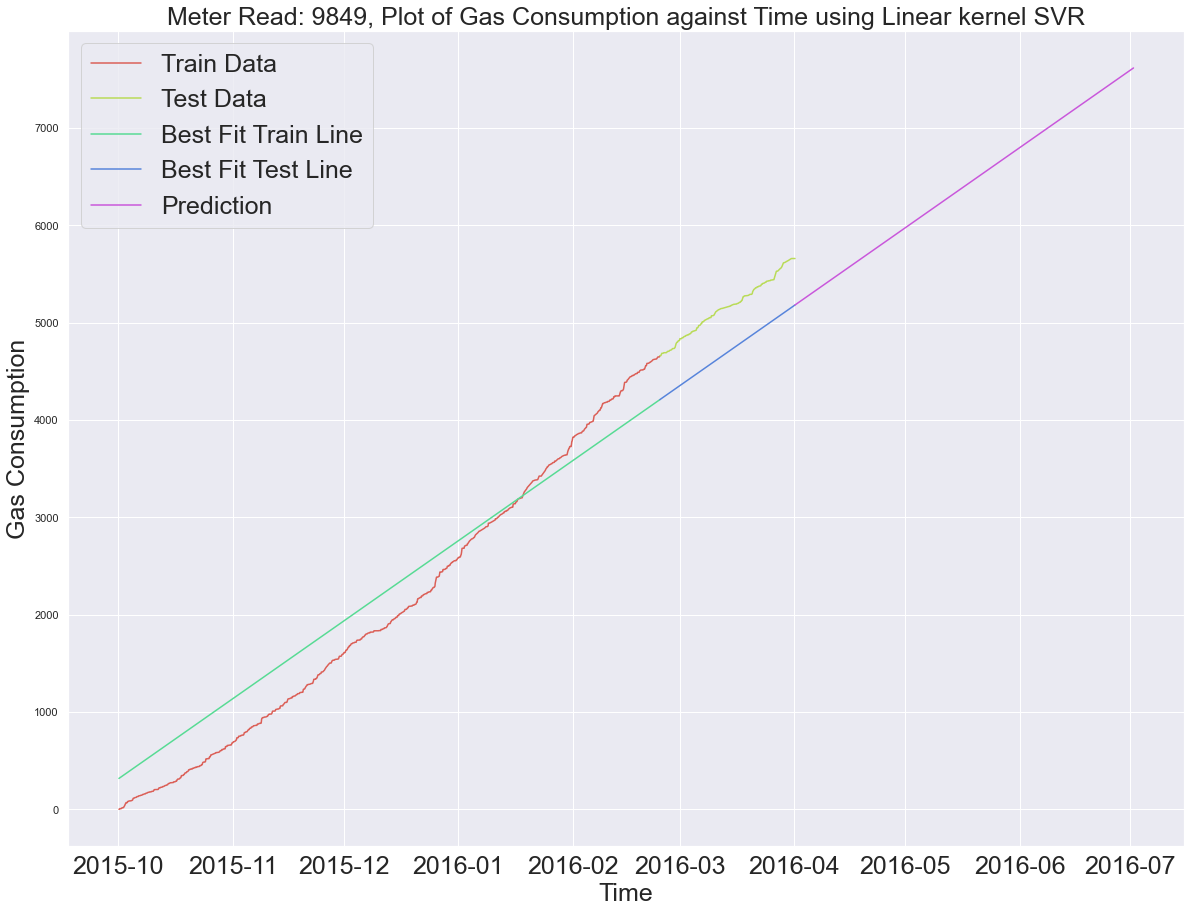

Visualizing the relationship using Scatter plot:



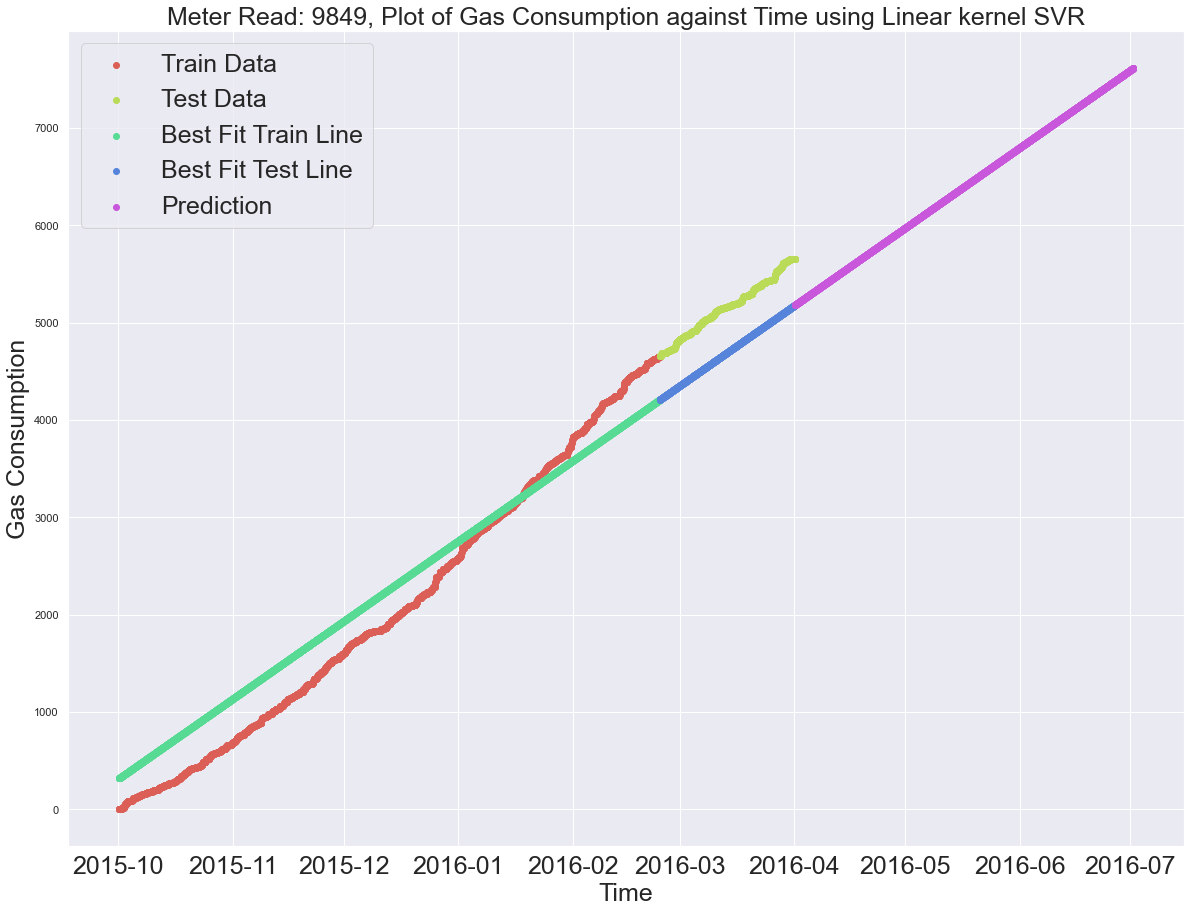

In [ ]:
svr_9849 = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"])
train_predict, test_predict, svr_module_name, future_predict_data = svr(svr_9849, train_date , test_date, train_input)
train_predict = scaler_inverse_transform_data(train_predict) 
test_predict = scaler_inverse_transform_data(test_predict)
future_predict_data = scaler_inverse_transform_data(future_predict_data)
test_data = scaler_inverse_transform_data(test_data)

print(f"The mean square error of the linear SVR on Test Data is {mean_squared_error(test_predict, test_data)}\n")

print('Visualizing the relationship using Time Series with Line plot:\n')
plot_line_svr(9849, train_predict, test_predict, future_predict_data, "linear")
show2(9849, 'Linear')

print('Visualizing the relationship using Scatter plot:\n')
plot_scatter_svr(9849, train_predict, test_predict, future_predict_data, "linear")
show2(9849, 'Linear')

## Plot for Meter 77 using Linear SVR Model 
### SVR Actual vs the Fit Line. 
Forecasting and using GridSearch method to find the optimal value for the hyperparameter C for linear kernel SVR

In [ ]:
train_data,test_data,test_date,train_date,new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(77)
scaler = fit_data_in_range(train_data)
train_data, test_data = scaler_transform_data(train_data), scaler_transform_data(test_data)
train_input=train_data.ravel()

parameters = parameter_dict(C_range, gamma_range)
    
grid = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', n_jobs = 6)
grid.fit(train_date, train_data.ravel())
print(f"The best parameters from GridSearch are {grid.best_params_}")

The best parameters from GridSearch are {'C': 0.0001, 'kernel': 'linear'}


<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The mean square error of the linear SVR on Test Data is 382266.3210262529

Visualizing the relationship using Time Series with Line plot:



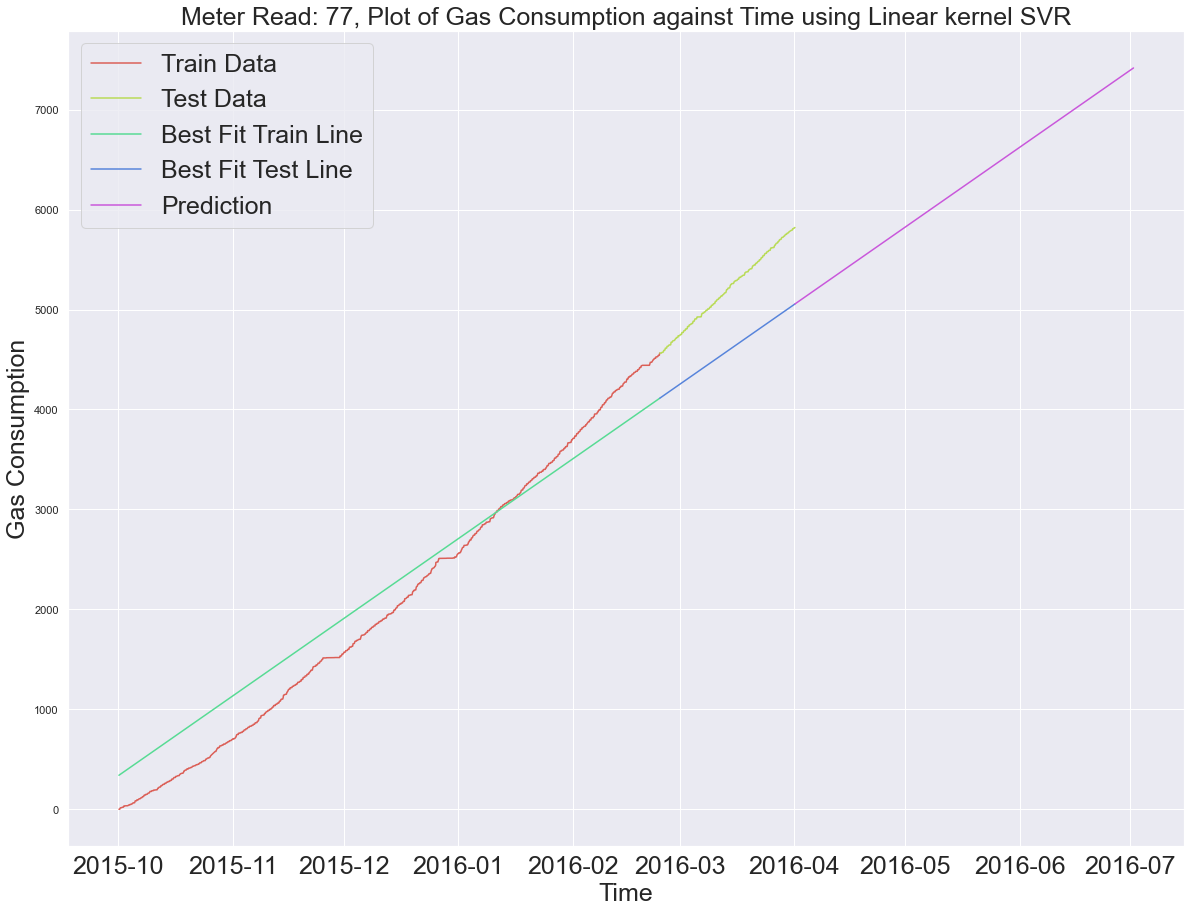

Visualizing the relationship using Scatter plot:



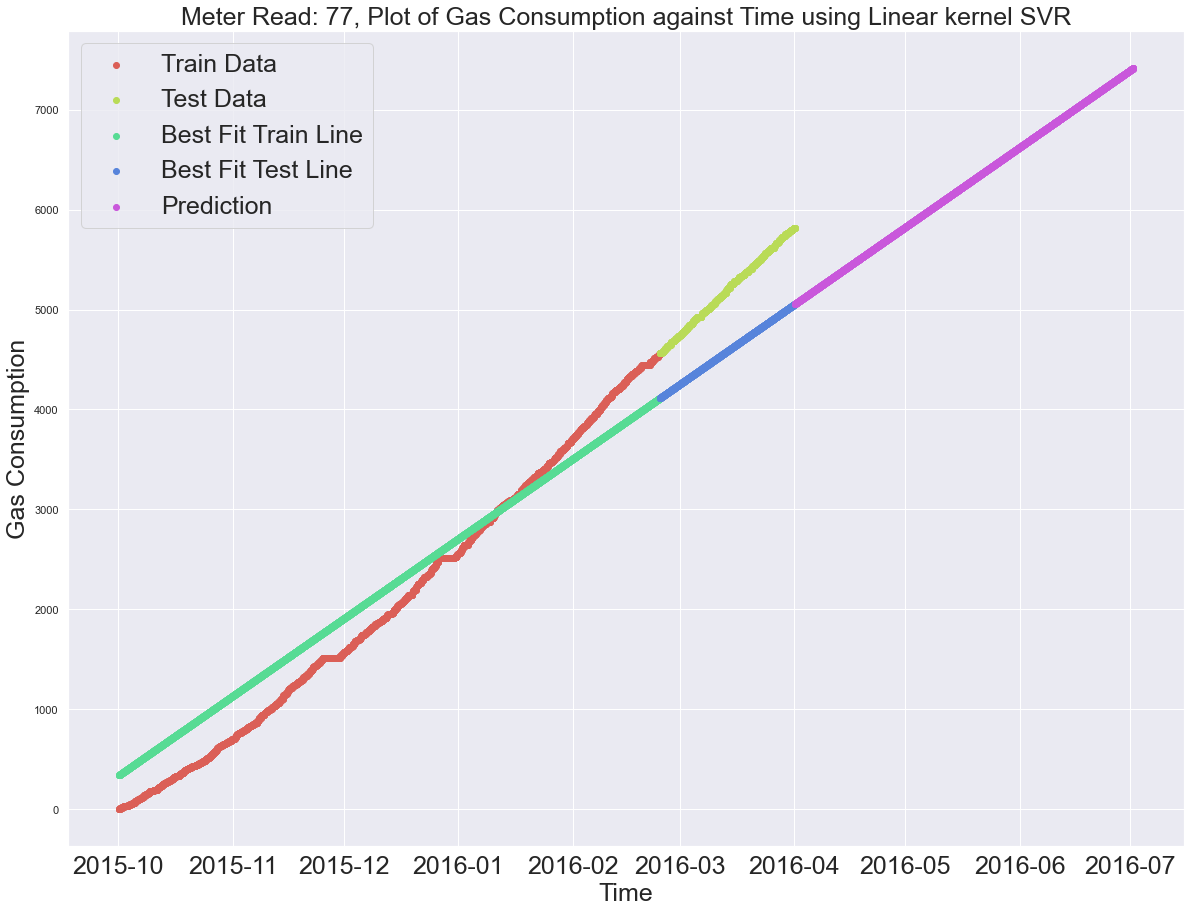

In [ ]:
svr_77 = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"])
train_predict, test_predict, svr_module_name, future_predict_data = svr(svr_77, train_date , test_date, train_input)
train_predict = scaler_inverse_transform_data(train_predict) 
test_predict = scaler_inverse_transform_data(test_predict)
future_predict_data = scaler_inverse_transform_data(future_predict_data)
test_data = scaler_inverse_transform_data(test_data)

print(f"The mean square error of the linear SVR on Test Data is {mean_squared_error(test_predict, test_data)}\n")

print('Visualizing the relationship using Time Series with Line plot:\n')
plot_line_svr(77, train_predict, test_predict, future_predict_data, "linear")
show2(77, 'Linear')

print('Visualizing the relationship using Scatter plot:\n')
plot_scatter_svr(77, train_predict, test_predict, future_predict_data, "linear")
show2(77, 'Linear')


## Plot for Meter 35 using Linear SVR Model 
### SVR Actual vs the Fit Line. 
Forecasting and using GridSearch method to find the optimal value for the hyperparameter C for linear kernel SVR

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(35)
scaler = fit_data_in_range(train_data)
train_data, test_data = scaler_transform_data(train_data), scaler_transform_data(test_data)
train_input=train_data.ravel()

parameters = parameter_dict(C_range, gamma_range)

grid = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', n_jobs = 6)
grid.fit(train_date, train_data.ravel())
print(f"The best parameters from GridSearch are {grid.best_params_}")

The best parameters from GridSearch are {'C': 0.0001, 'kernel': 'linear'}


<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The mean square error of the linear SVR on Test Data is 328506.8710664356

Visualizing the relationship using Time Series with Line plot:



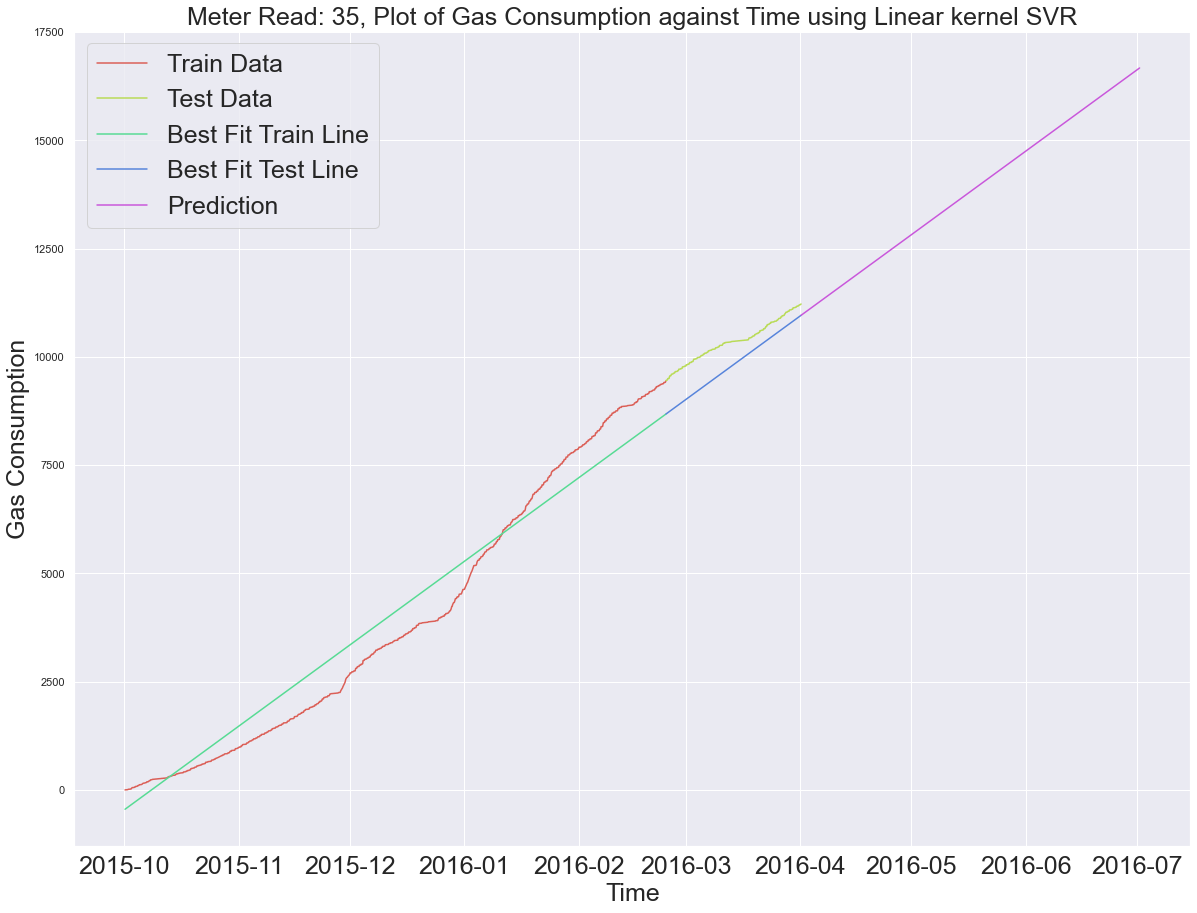

Visualizing the relationship using Scatter plot:



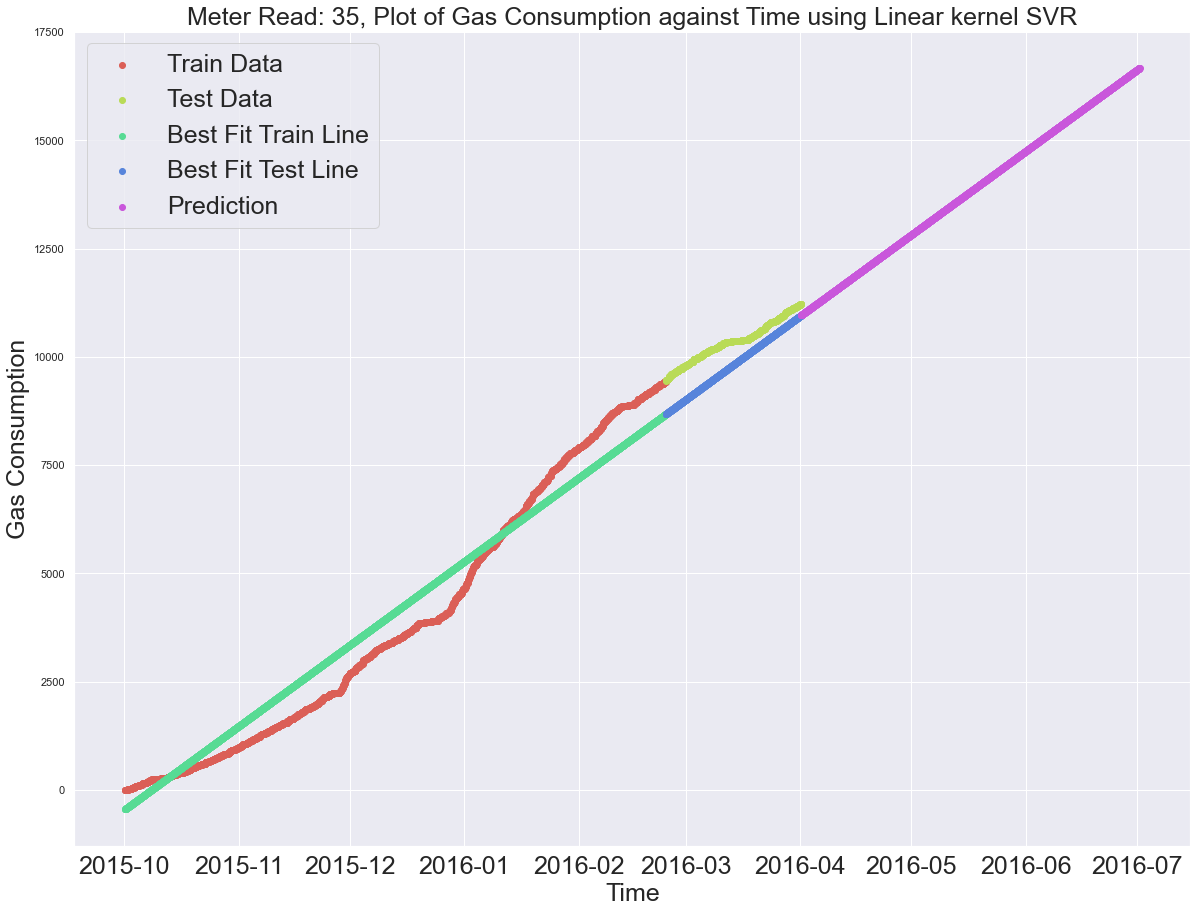

In [ ]:
svr_35 = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"])
train_predict,test_predict,svr_module_name, future_predict_data = svr(svr_35, train_date , test_date, train_input)
train_predict = scaler_inverse_transform_data(train_predict)
test_predict = scaler_inverse_transform_data(test_predict)
future_predict_data = scaler_inverse_transform_data(future_predict_data)
test_data = scaler_inverse_transform_data(test_data)

print(f"The mean square error of the linear SVR on Test Data is {mean_squared_error(test_predict, test_data)}\n")

print('Visualizing the relationship using Time Series with Line plot:\n')
plot_line_svr(35, train_predict, test_predict, future_predict_data, "linear")
show2(35, 'Linear')

print('Visualizing the relationship using Scatter plot:\n')
plot_scatter_svr(35, train_predict, test_predict, future_predict_data, "linear")
show2(35, 'Linear')


## Plot for Meter 9849 using RBF SVR Model 
### SVR Actual vs the Fit Line. 
Using GridSearch method to find the optimal hyperparameter C value and gamma value for Radial Basis Function (RBF) kernel SVR

In [ ]:
# Defining variables 

gamma_range = np.logspace(-15, 1, 7)
C_range = np.logspace(-10, 10, 6)

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(9849)
scaler = fit_data_in_range(train_data)
train_data = scaler_transform_data(train_data)
test_data = scaler_transform_data(test_data)
train_input = train_data.ravel()

parameters = parameter_dict(C_range, gamma_range)
    
grid = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', n_jobs = 6)
grid.fit(train_date, train_data.ravel())
print(f"The best parameters from GridSearch are {grid.best_params_}")

<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The best parameters from GridSearch are {'C': 1000000.0, 'gamma': 4.641588833612772e-13, 'kernel': 'rbf'}


The mean square error of the RBF SVR on Test Data is 207322.34590328456

Visualizing the relationship using Time Series with Line plot:



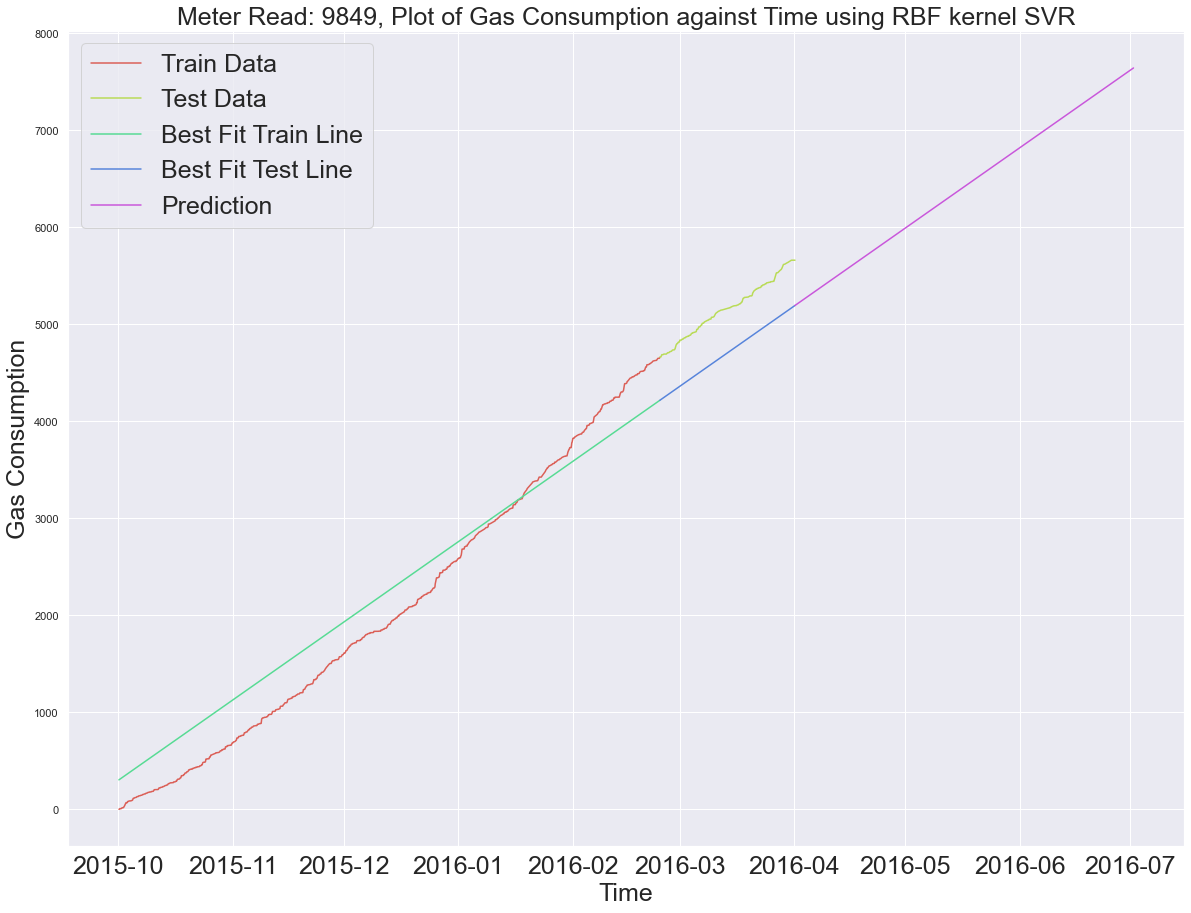

Visualizing the relationship using Scatter plot:



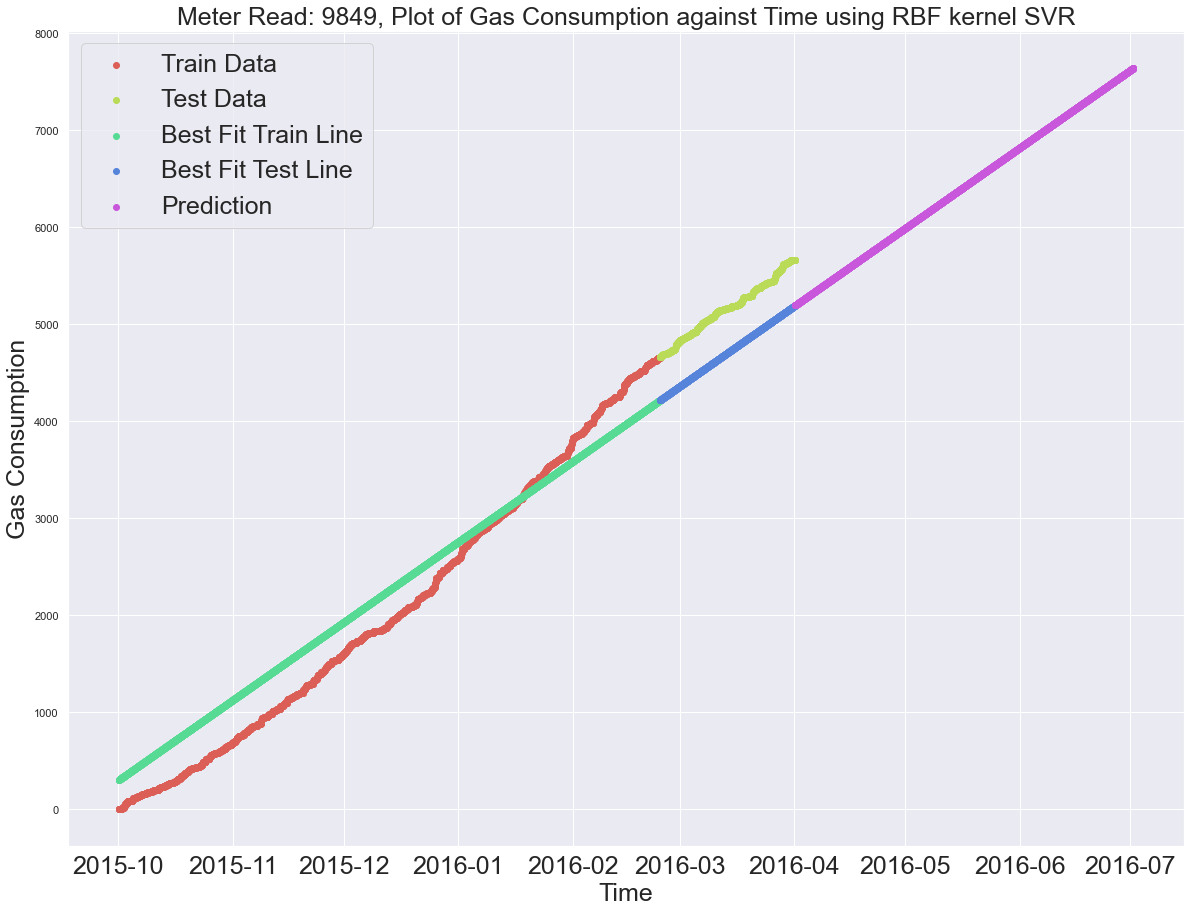

In [ ]:
svr_rbf = SVR(kernel = grid.best_params_["kernel"], C = grid.best_params_["C"], gamma = grid.best_params_['gamma'])
train_predict, test_predict, svr_module_name, future_predict_data = svr(svr_rbf, train_date , test_date, train_input)
train_predict = scaler_inverse_transform_data(train_predict)
test_predict = scaler_inverse_transform_data(test_predict)
future_predict_data = scaler_inverse_transform_data(future_predict_data) 
test_data = scaler_inverse_transform_data(test_data)

print(f"The mean square error of the RBF SVR on Test Data is {mean_squared_error(test_predict, test_data)}\n")

print('Visualizing the relationship using Time Series with Line plot:\n')
plot_line_svr(9849, train_predict, test_predict, future_predict_data, "rbf")
show2(9849, 'RBF')

print('Visualizing the relationship using Scatter plot:\n')
plot_scatter_svr(9849, train_predict, test_predict, future_predict_data, "rbf")
show2(9849, 'RBF')

## Plot for Meter 77 using RBF SVR Model 
### SVR Actual vs the Fit Line. 
Using GridSearch method to find the optimal hyperparameter C value and gamma value for Radial Basis Function (RBF) kernel SVR

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(77)
scaler = fit_data_in_range(train_data)
train_data = scaler_transform_data(train_data)
test_data = scaler_transform_data(test_data)
train_input = train_data.ravel()

parameters = parameter_dict(C_range, gamma_range)
    
grid = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', n_jobs = 6)
grid.fit(train_date, train_data.ravel())
print(f"The best parameters from GridSearch are {grid.best_params_}")

<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The best parameters from GridSearch are {'C': 1000000.0, 'gamma': 4.641588833612772e-13, 'kernel': 'rbf'}


The mean square error of the RBF SVR on Test Data is 370472.65531699004

Visualizing the relationship using Time Series with Line plot:



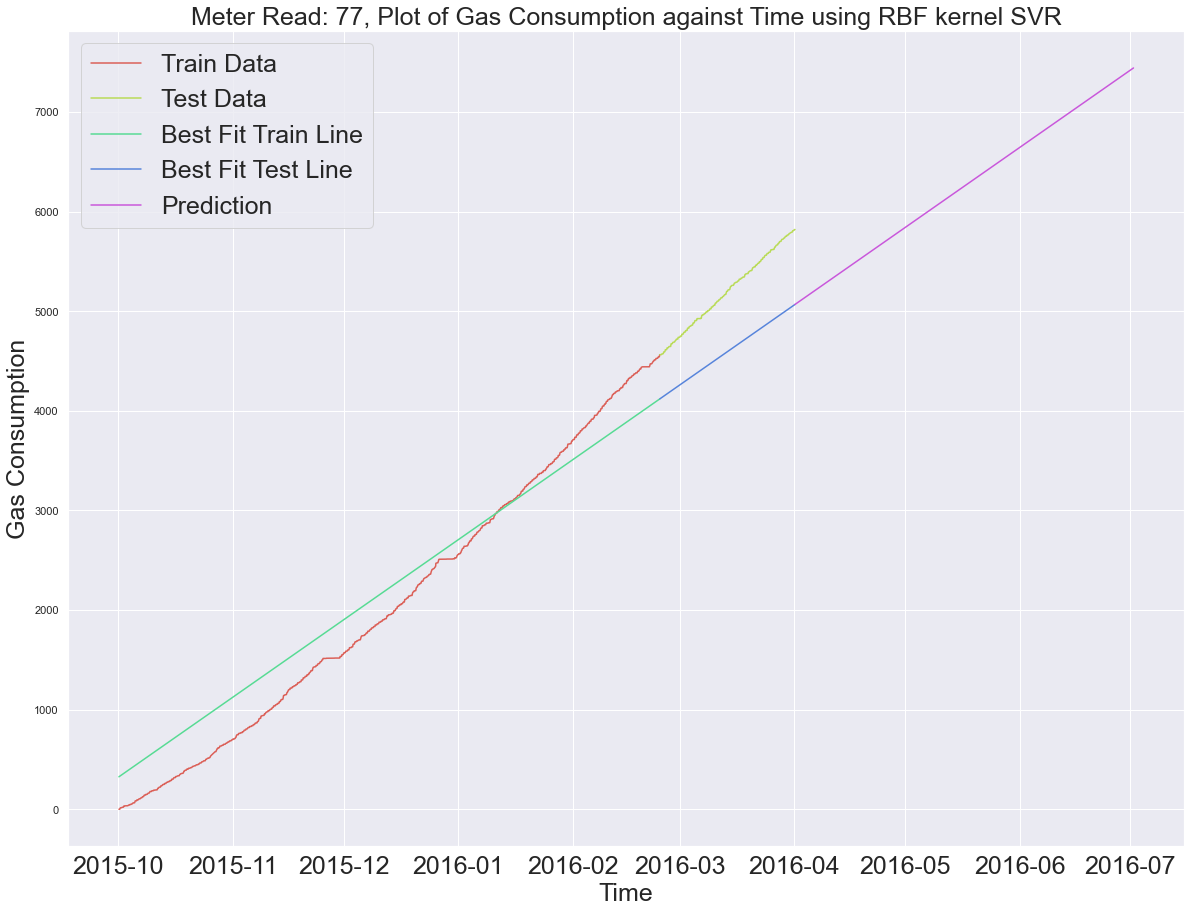

Visualizing the relationship using Scatter plot:



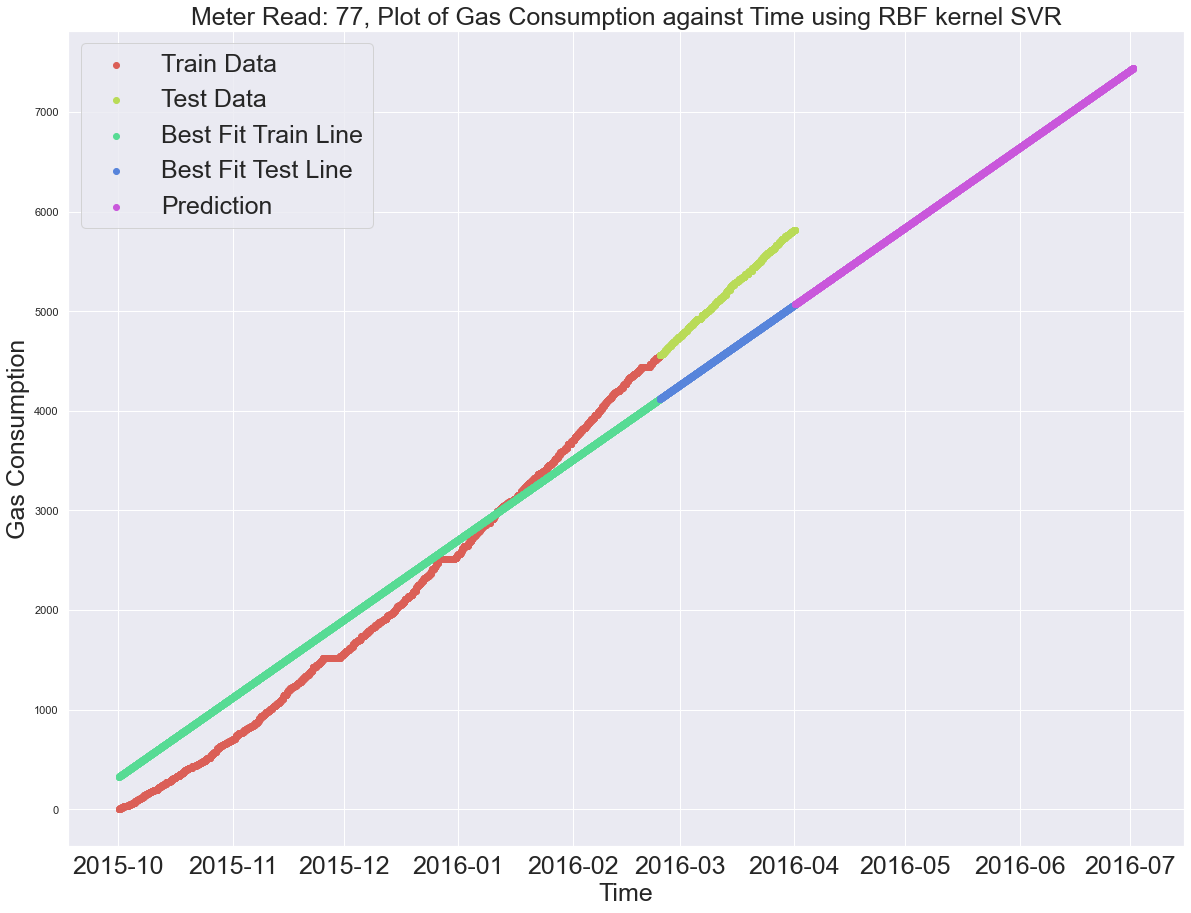

In [ ]:
svr_rbf = SVR(kernel = grid.best_params_["kernel"], C = grid.best_params_["C"], gamma = grid.best_params_['gamma'])
train_predict,  test_predict,  svr_module_name, future_predict_data = svr(svr_rbf, train_date , test_date, train_input)
train_predict = scaler_inverse_transform_data(train_predict)
test_predict = scaler_inverse_transform_data(test_predict)
future_predict_data = scaler_inverse_transform_data(future_predict_data) 
test_data = scaler_inverse_transform_data(test_data)

print(f"The mean square error of the RBF SVR on Test Data is {mean_squared_error(test_predict, test_data)}\n")

print('Visualizing the relationship using Time Series with Line plot:\n')
plot_line_svr(77, train_predict, test_predict, future_predict_data, "rbf")
show2(77, 'RBF')

print('Visualizing the relationship using Scatter plot:\n')
plot_scatter_svr(77, train_predict, test_predict, future_predict_data, "rbf")
show2(77, 'RBF')

## Plot for Meter 35 using RBF SVR Model 
### SVR Actual vs the Fit Line. 
Using GridSearch method to find the optimal hyperparameter C value and gamma value for Radial Basis Function (RBF) kernel SVR

In [ ]:
train_data, test_data, test_date, train_date, new_date_range, train_data_duplicate, test_data_duplicate = preprocessed_data(35)
scaler = fit_data_in_range(train_data)
train_data = scaler_transform_data(train_data)
test_data = scaler_transform_data(test_data)
train_input = train_data.ravel()

parameters = parameter_dict(C_range, gamma_range)
    
grid = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error', n_jobs = 6)
grid.fit(train_date, train_data.ravel())
print(f"The best parameters from GridSearch are {grid.best_params_}")

<ipython-input-250-5647905e27fd>:13: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_date = (date[:train_size][:, None]).astype('datetime64[h]')
<ipython-input-250-5647905e27fd>:14: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_date = (date[train_size:dataset_size][:, None]).astype('datetime64[h]')


The best parameters from GridSearch are {'C': 1000000.0, 'gamma': 4.641588833612772e-13, 'kernel': 'rbf'}


The mean square error of the RBF SVR on Test Data is 240925.60691847993

Visualizing the relationship using Time Series with Line plot:



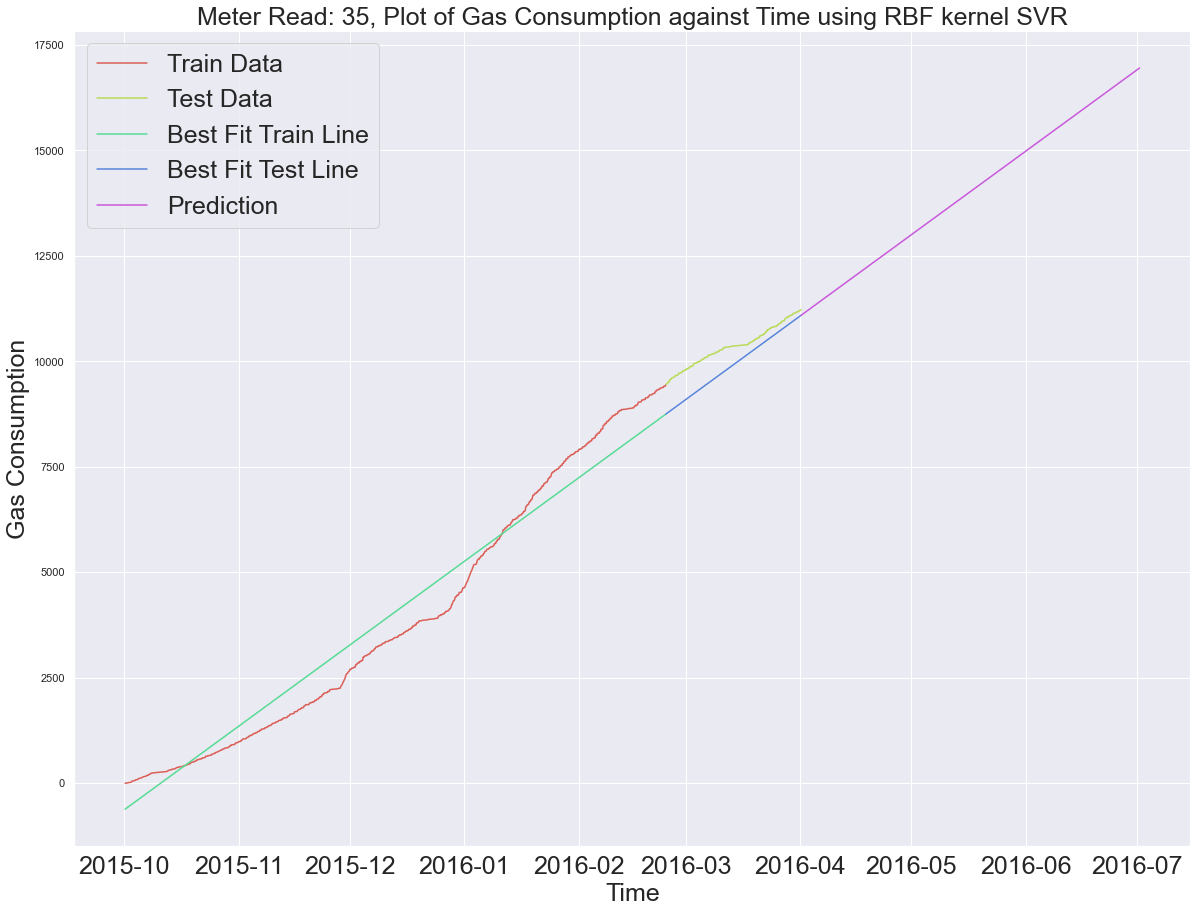

Visualizing the relationship using Scatter plot:



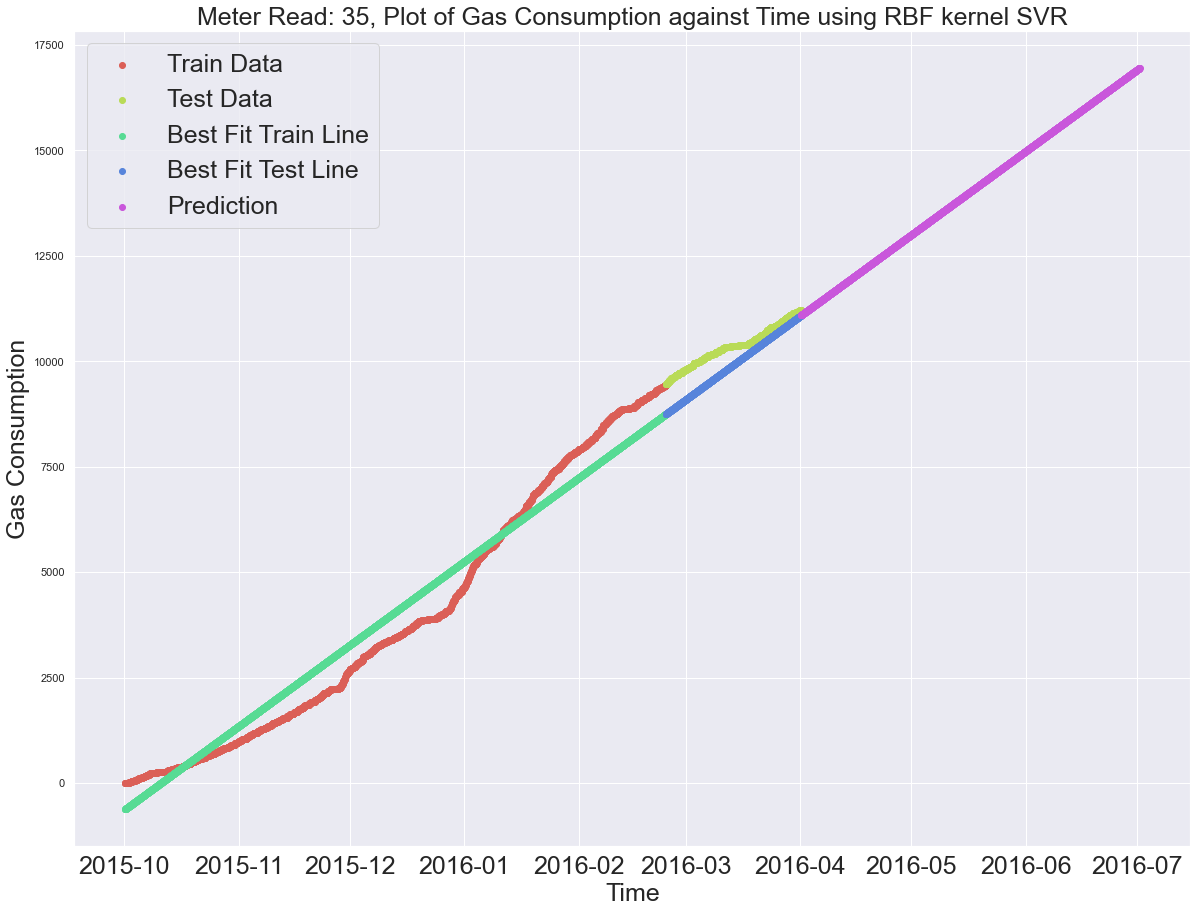

In [ ]:
svr_rbf = SVR(kernel = grid.best_params_["kernel"], C = grid.best_params_["C"], gamma = grid.best_params_['gamma'])
train_predict,  test_predict,  svr_module_name, future_predict_data = svr(svr_rbf, train_date , test_date, train_input)
train_predict = scaler_inverse_transform_data(train_predict)
test_predict = scaler_inverse_transform_data(test_predict)
future_predict_data = scaler_inverse_transform_data(future_predict_data) 
test_data = scaler_inverse_transform_data(test_data)

print(f"The mean square error of the RBF SVR on Test Data is {mean_squared_error(test_predict, test_data)}\n")

print('Visualizing the relationship using Time Series with Line plot:\n')
plot_line_svr(35, train_predict, test_predict, future_predict_data, "rbf")
show2(35, 'RBF')

print('Visualizing the relationship using Scatter plot:\n')
plot_scatter_svr(35, train_predict, test_predict, future_predict_data, "rbf")
show2(35, 'RBF')

## Conclusion of Q2:
In the analysis above, Linear Regression is observed to be performing better than Support Vector Regression in terms of Mean Squared Error. The reason for that is the optimization objectives of Linear Regression is minimizing the Mean Squared error ; however, Support Vector Regression focuses on maximizing the margin between the support vectors to form the best-fit line. 

The different models differs based on its intrinsic property. As we are doing forecasting, we feel that it is more important in reducing errors and having good margin. Comparing the 3 techniques, we feel that RBF SVM might be the better alternative. 
